## Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from utils.plot import Plot
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from Regularizations.models.ridge import RidgeRegularization
from Regularizations.models.lasso import LassoCoordinate, LassoGradient
from Regularizations.models.elastic_net import ElasticNetCoordinate, ElasticNetGradient

## Set display options

In [3]:
pd.set_option("display.max_columns", 100)
pd.set_option("expand_frame_repr", False)

## Load and inspect the dataset

In [4]:
df = pd.read_csv("../data/winequality-red.csv")
print(df.head())
print(df.info())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
0            7.4              0.70         0.00             1.9      0.076                 11.0                  34.0   0.9978  3.51       0.56      9.4        5
1            7.8              0.88         0.00             2.6      0.098                 25.0                  67.0   0.9968  3.20       0.68      9.8        5
2            7.8              0.76         0.04             2.3      0.092                 15.0                  54.0   0.9970  3.26       0.65      9.8        5
3           11.2              0.28         0.56             1.9      0.075                 17.0                  60.0   0.9980  3.16       0.58      9.8        6
4            7.4              0.70         0.00             1.9      0.076                 11.0                  34.0   0.9978  3.51       0.56      9.4        5
<class 'pandas.core.frame.Da

## Distribution of wine data

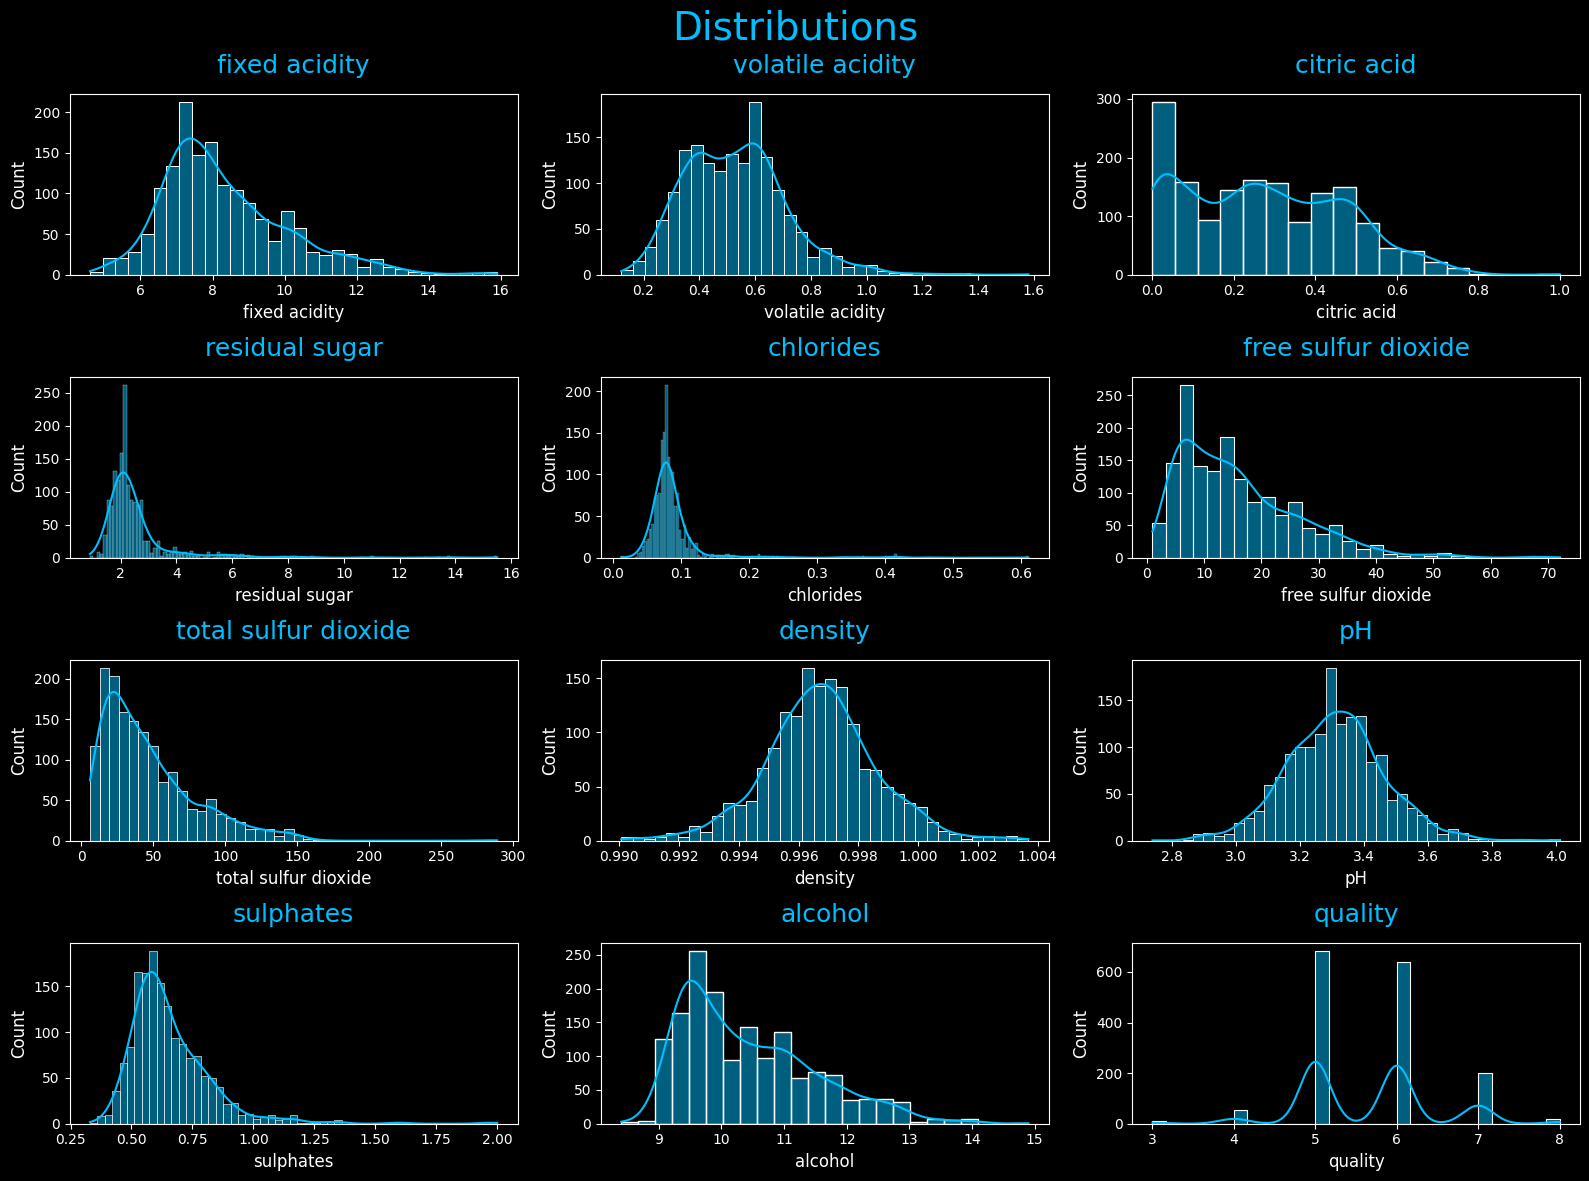

In [4]:
Plot.set_plot_params(figsize = (16,12))
Plot.histplot(data=df, rows=4, columns=3, color="deepskyblue")

Most of the data we have is with "average" quality (quality = 5 or 6)

## Plot feature vs target

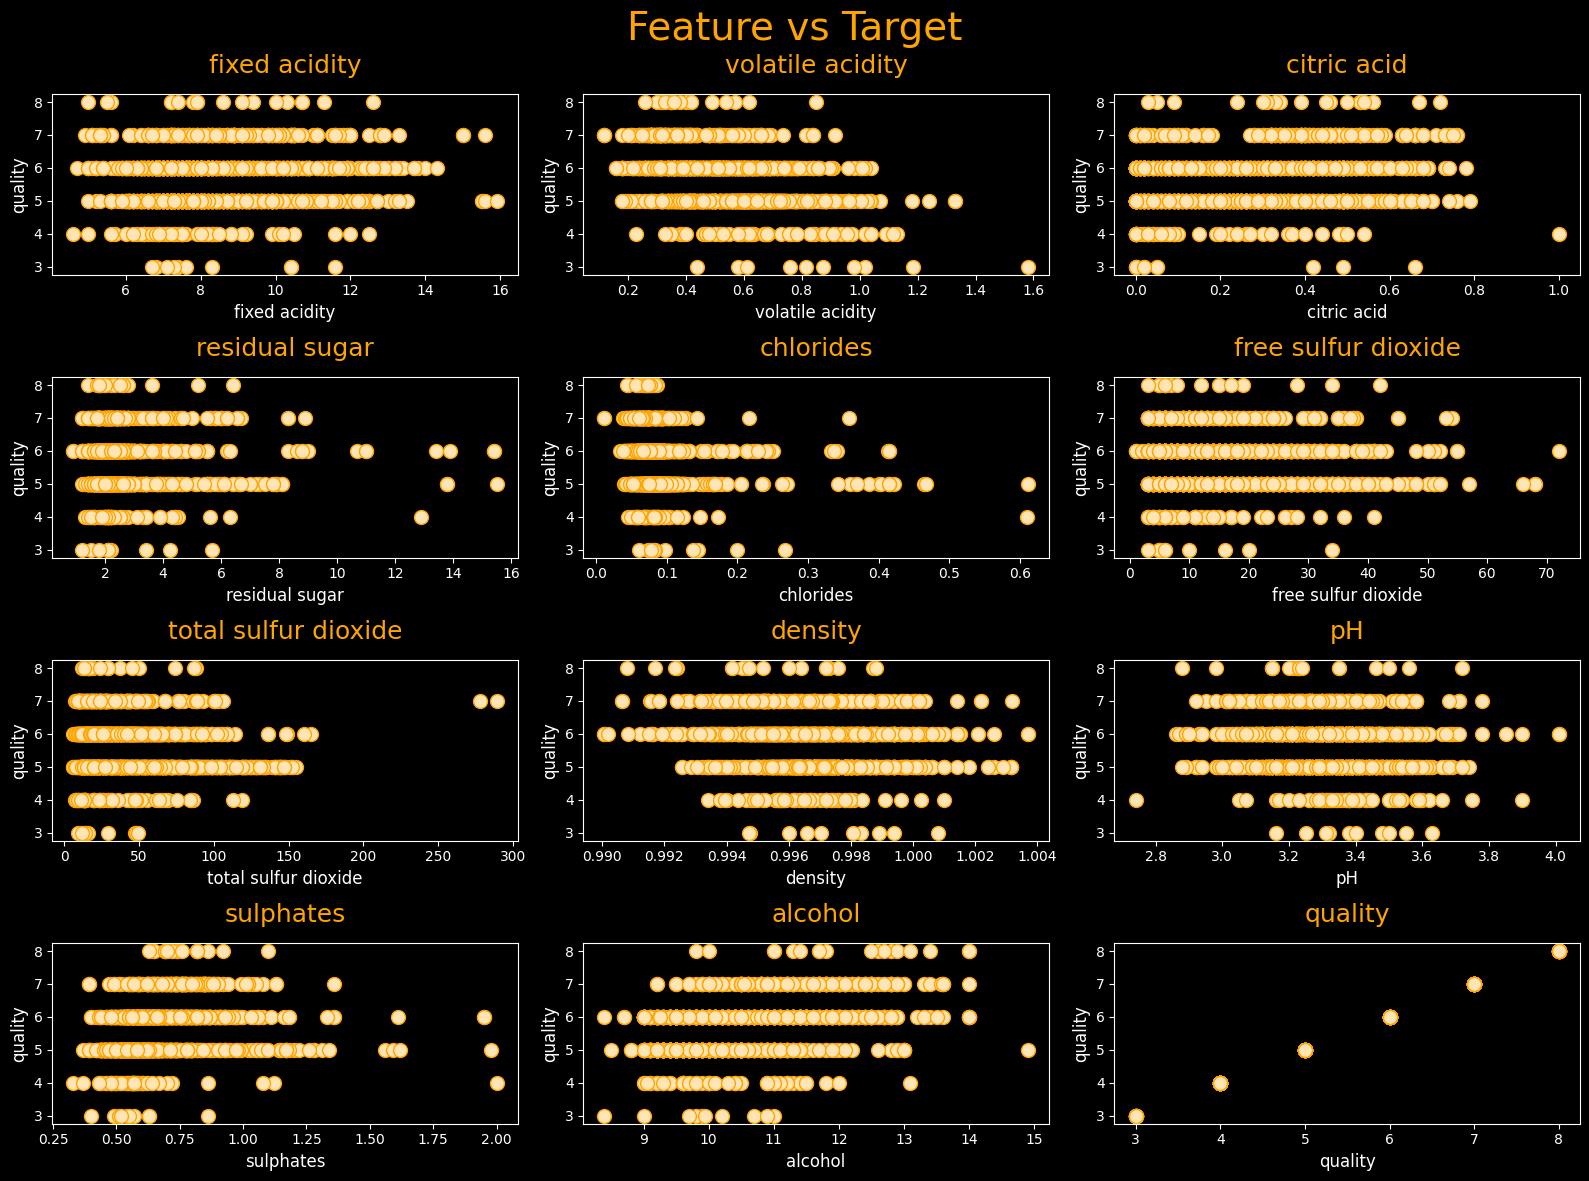

In [5]:
Plot.feature_vs_target(data=df, target="quality", rows=4, columns=3, color="orange", scatter_color="moccasin")

## Split data into features and target

In [5]:
X = df.drop(columns=["quality"]).values
y = df["quality"].values

## Split data into trainig and testing sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize the data

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Fit Linear Regression

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

## Linear Regression Train Accuracy

In [10]:
y_pred_train = model.intercept_ + np.dot(X_train, model.coef_)
y_pred_train = np.round(y_pred_train)
print(np.mean(y_train == y_pred_train))

0.5949960906958561


## Linear Regression Test Accuracy

In [11]:
print(np.mean(y_test == y_pred))

0.571875


Accuracy of the model is very low. We will create **Polynomial Features** to increase variance and accuracy.

## Polynomial Regression

Compare the train and test accuracies of Polynomial Regression across different polynomial degrees.

In [12]:
degrees = 10

train_accuracies = []
test_accuracies = []

for degree in range(degrees):
    pf = PolynomialFeatures(degree=degree + 1)
    X_train_pf = pf.fit_transform(X_train)
    X_test_pf = pf.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_pf, y_train)

    y_pred = np.round(model.predict(X_test_pf))
    y_pred_train = np.round(model.intercept_ + np.dot(X_train_pf, model.coef_))

    test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    train_accuracy = accuracy_score(y_true=y_train, y_pred=y_pred_train)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

In [13]:
def get_train_test_params(train_accuracies, test_accuracies):
    train_test_params = [
        {
            "y": train_accuracies,
            "title": "Train",
            "scatter_color": "lightblue",
            "color": "deepskyblue",
        },
        {
            "y": test_accuracies,
            "title": "Test",
            "scatter_color": "moccasin",
            "color": "orange",
        }
    ]

    return train_test_params

In [14]:
train_test_params = get_train_test_params(train_accuracies=train_accuracies, test_accuracies=test_accuracies)

## Train accuracy vs test accuracy accross polynomial degrees

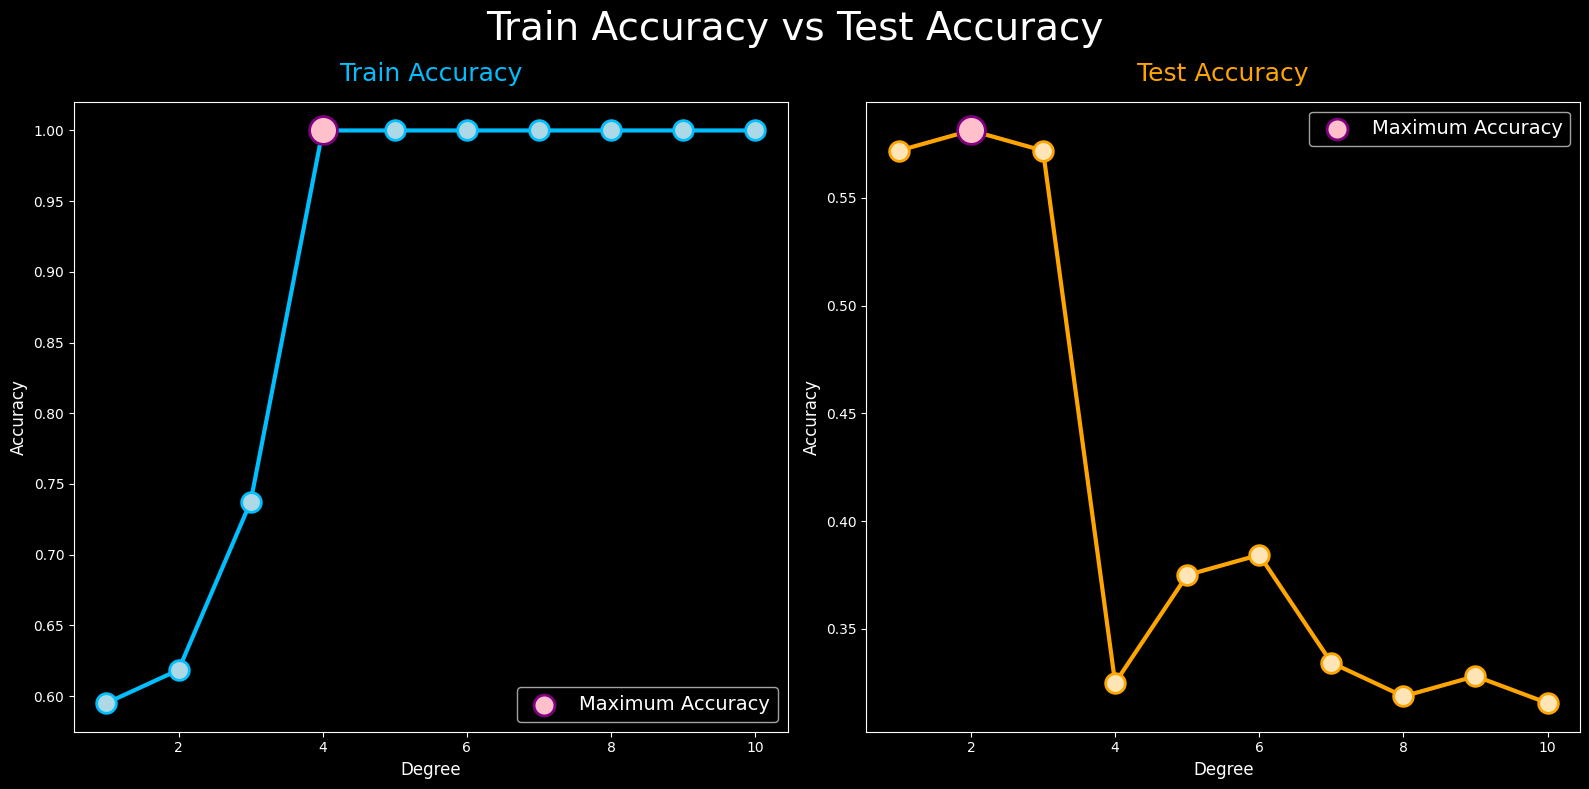

In [15]:
Plot.train_vs_test_accuracy(train_test_params=train_test_params, x=range(1, degrees + 1), x_label="Degree",
                            suptitle="Train Accuracy vs Test Accuracy")

Best training accuracy starts from polynomial degree = 4 and then remains the same (100%). However, testing accuracy has the best score when polynomial degree = 2 and after degree = 3 drastically drops. Such behaviour shows that we have an overfitting problem after polynomial degree = 2. To overcome this problem we will add regularization term to ower Linear Regression model.

## Regularization Terms

We will compare three different regularizations: 

 - **Ridge Regression** or **L2 Norm/Regularization**

 - **LASSO (Least Absolute Shrinkage and Selection Operator)** or **L1 Norm/Regularization**,

 - **Elastic Net Regularization**

 

## Ridge Regression or L2 Norm/Regularization

### Choose degrees which compare

We will choose the polynomial degree = 4, since it is the first degree that got 100% accuracy in training set. Also we will choose polynomial degree = 3 as in testing set it is the last polynomial degree before the drastic drop in accuracy. We will compare different regularizations between these two polynomial degrees.

In [16]:
degrees = [3, 4]

### Custom Ridge vs Sklearn Ridge

I will compare my custom built Ridge Regularization model and Ridge model from Sklearn

In [17]:
models = [
    {
        "model": RidgeRegularization,
        "title": "Custom Ridge"
    },
    {
        "model": Ridge,
        "title": "Sklearn Ridge"
    }
]

In [18]:
def get_model(model, alpha, learning_rate, l1_ratio):
    if model == LassoGradient:
        regression = model(alpha=alpha, learning_rate=learning_rate)
    elif model == ElasticNet or model == ElasticNetCoordinate:
        regression = model(alpha=alpha, l1_ratio=l1_ratio)
    elif model == ElasticNetGradient:
        regression = model(alpha=alpha, l1_ratio=l1_ratio, learning_rate=learning_rate)
    else:
        regression = model(alpha=alpha)
    
    return regression
    

In [19]:
def is_coordinate(model):
    coordinate_models = [LassoCoordinate, ElasticNetCoordinate]
    if model in coordinate_models:
        return True
    else:
        return False

In [20]:
def is_gradient(model):
    gradient_models = [LassoGradient, ElasticNetGradient]
    if model in gradient_models:
        return True
    else:
        return False

In [21]:
def get_model_train_test_accuracies(degrees, models, alphas, coordinate_iterations=None, 
                                    gradient_iterations=None, learning_rate=None, l1_ratio=None):
    
    models_degrees_data = []

    for degree in degrees:

        pf = PolynomialFeatures(degree=degree)
        X_train_pf = pf.fit_transform(X_train)
        X_test_pf = pf.transform(X_test)

        test_accuracies = []
        train_accuracies = []

        for model in models:

            for alpha in alphas:

                regression = get_model(model=model["model"], alpha=alpha, learning_rate=learning_rate, l1_ratio=l1_ratio)

                if is_coordinate(model=model["model"]):
                    regression.fit(X_train=X_train_pf, y_train=y_train, iterations=coordinate_iterations)
                elif is_gradient(model=model["model"]):
                    regression.fit(X_train=X_train_pf, y_train=y_train, iterations=gradient_iterations)
                else:
                    regression.fit(X_train_pf, y_train)

                y_pred = np.round(regression.predict(X_test_pf)).astype(int)
                y_pred_train = np.round(regression.intercept_ + np.dot(X_train_pf, regression.coef_)).astype(int)

                test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
                train_accuracy = accuracy_score(y_true=y_train, y_pred=y_pred_train)

                test_accuracies.append(test_accuracy)
                train_accuracies.append(train_accuracy)
            
            models_degrees_data.append(
                {
                    "title": model["title"],
                    "degree": degree,
                    "test_accuracies": test_accuracies,
                    "train_accuracies": train_accuracies,
                    "alphas": alphas
                }
            )

            # clear test and train accuracies arrays for next model
            test_accuracies = []
            train_accuracies = []


    return models_degrees_data

In [22]:
alphas = [0.001, 0.01, 0.1, 1, 2, 5, 10, 100, 200, 300, 350, 400, 500, 600, 700, 800, 900, 1000]
models_degrees_data = get_model_train_test_accuracies(degrees=degrees, models=models, alphas=alphas)

In [23]:
def plot_model_accuracies(models_degrees_data):
    for model_degree_data in models_degrees_data:
        train_test_params = get_train_test_params(train_accuracies=model_degree_data["train_accuracies"],
                                                test_accuracies=model_degree_data["test_accuracies"])
        
        suptitle = f"{model_degree_data["title"]}, Degree - {model_degree_data["degree"]}"
        Plot.train_vs_test_accuracy(train_test_params=train_test_params, x=model_degree_data["alphas"], 
                                    x_label="Alpha", suptitle=suptitle)


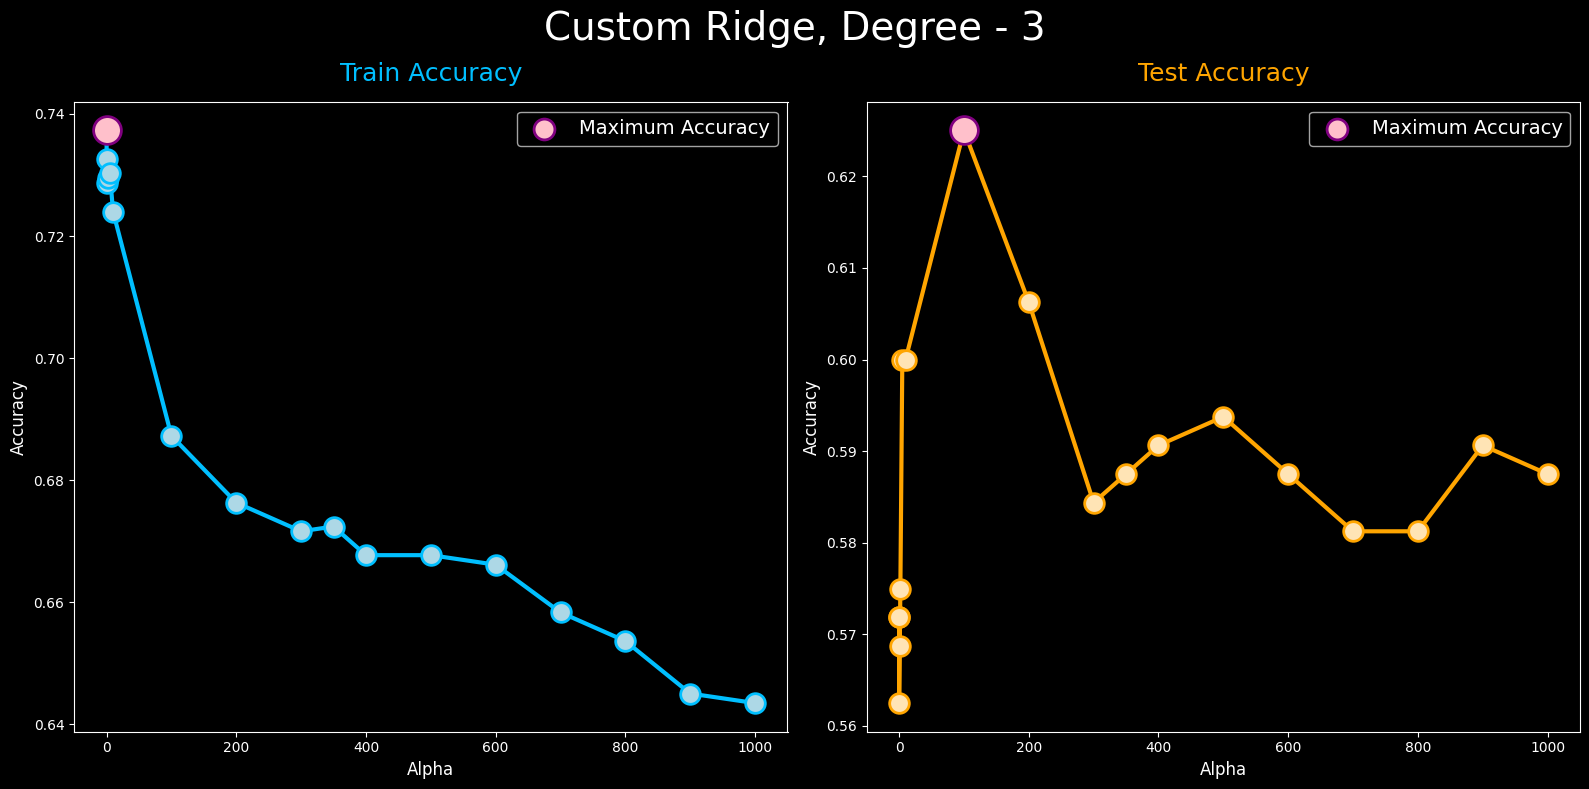

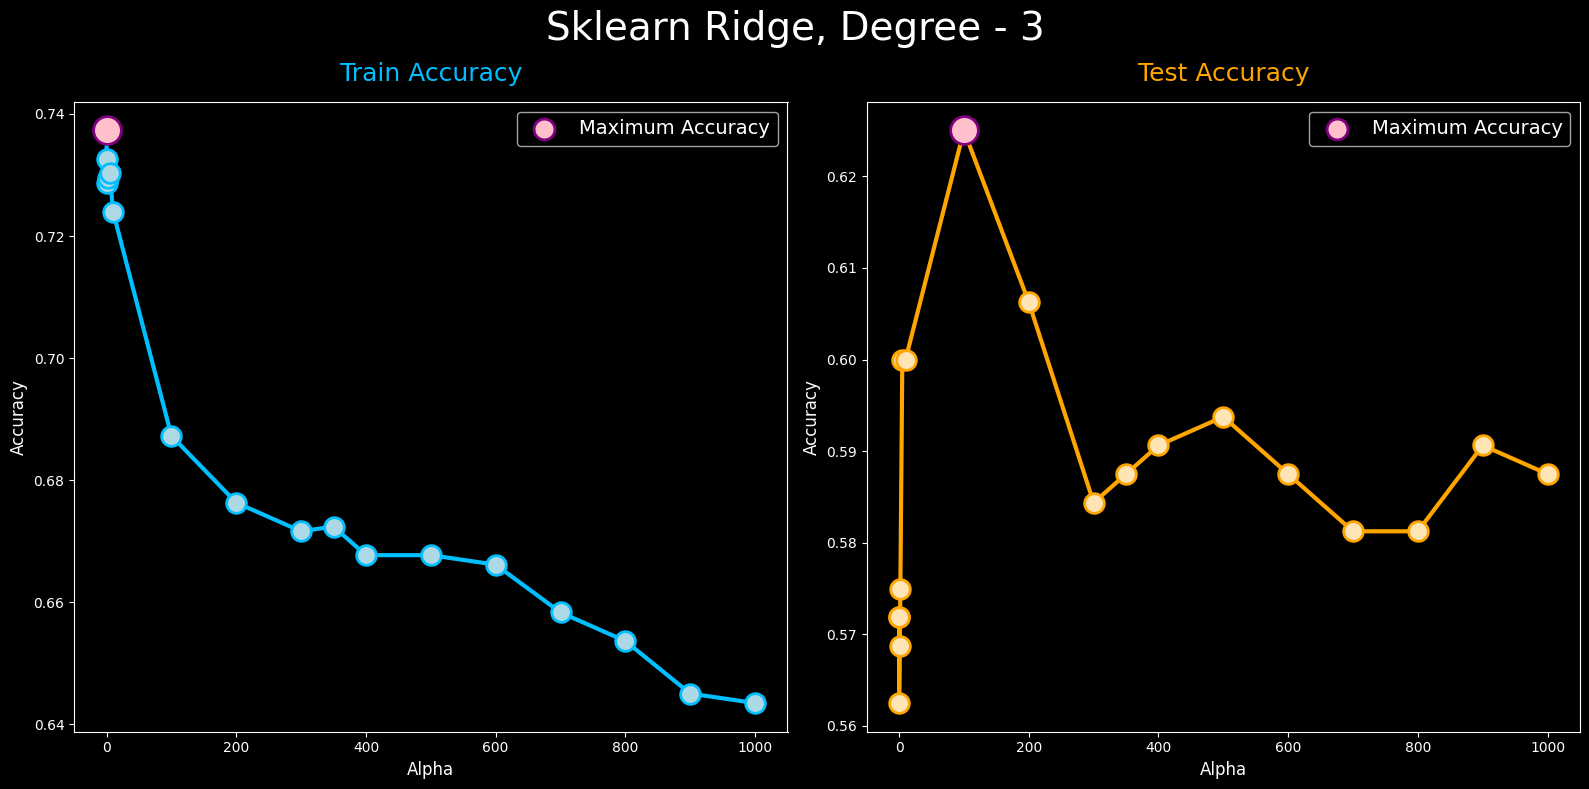

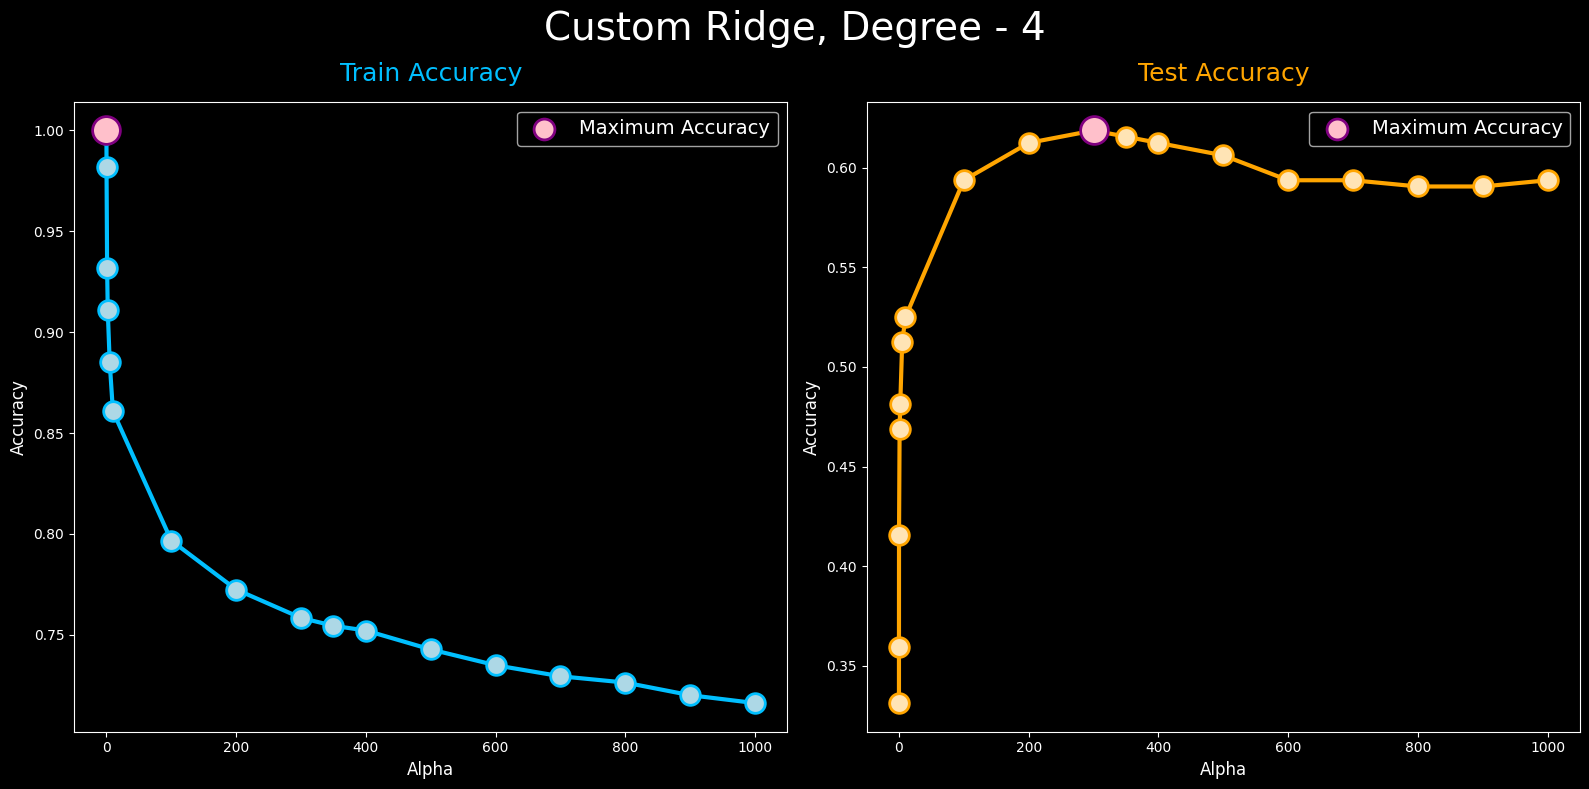

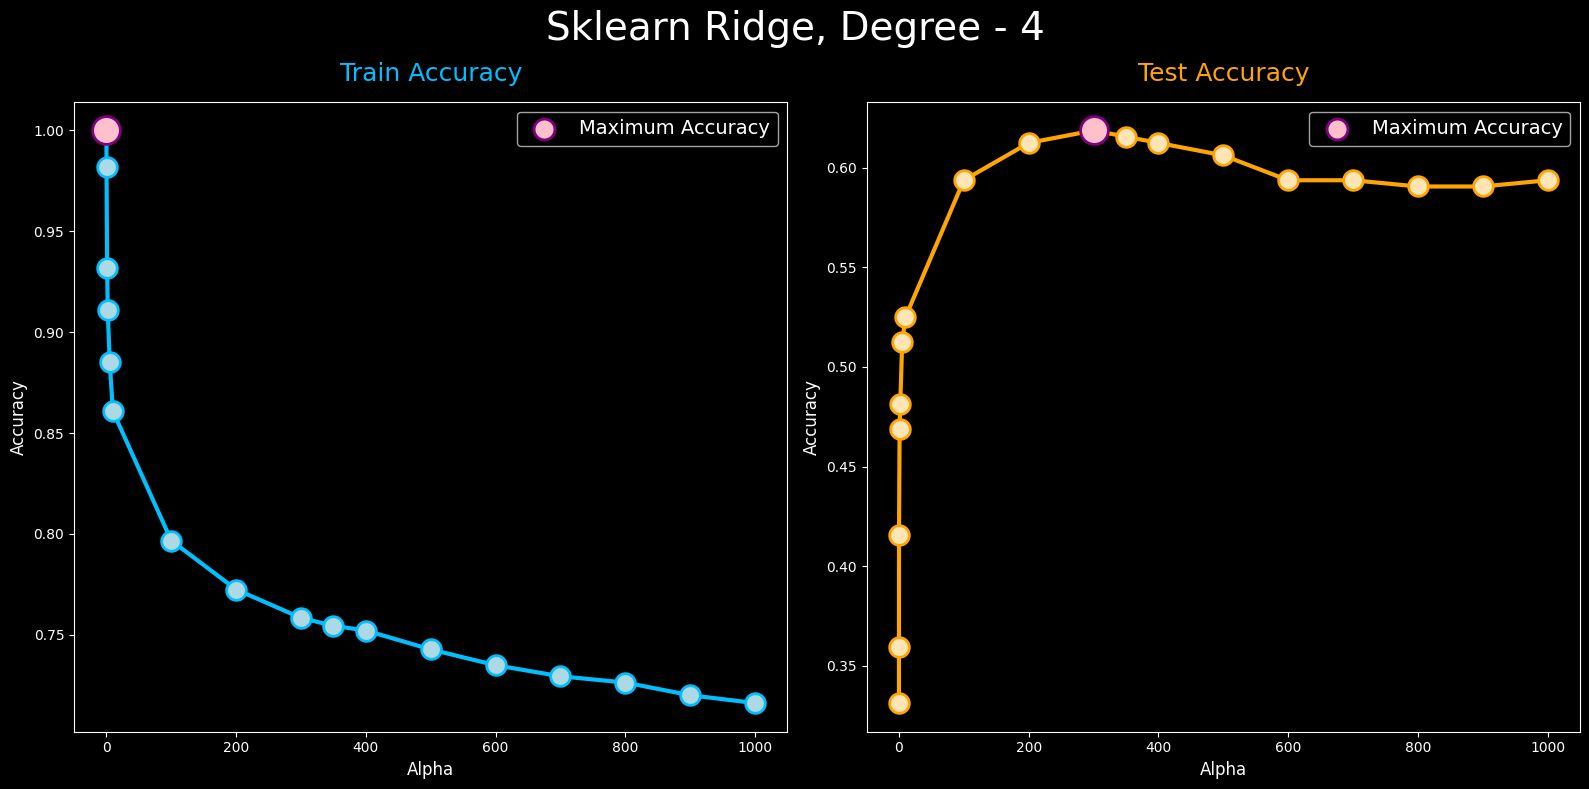

In [24]:
plot_model_accuracies(models_degrees_data=models_degrees_data)

In [25]:
def get_models_report(models_degrees_data):
    for model_degree_data in models_degrees_data:
        print(f"Model:                 {model_degree_data["title"]}")
        print(f"Degree:                {model_degree_data["degree"]}")
        print(f"Max train accuracy:    {np.max(model_degree_data["train_accuracies"])}")
        print(f"Max train alpha:       {model_degree_data["alphas"][np.argmax(model_degree_data["train_accuracies"])]}")
        print(f"Max test accuracy:     {np.max(model_degree_data["test_accuracies"])}")
        print(f"Max test alpha:        {model_degree_data["alphas"][np.argmax(model_degree_data["test_accuracies"])]}")
        print("----------------------------------------")

In [26]:
get_models_report(models_degrees_data=models_degrees_data)

Model:                 Custom Ridge
Degree:                3
Max train accuracy:    0.7372947615324472
Max train alpha:       0.001
Max test accuracy:     0.625
Max test alpha:        100
----------------------------------------
Model:                 Sklearn Ridge
Degree:                3
Max train accuracy:    0.7372947615324472
Max train alpha:       0.001
Max test accuracy:     0.625
Max test alpha:        100
----------------------------------------
Model:                 Custom Ridge
Degree:                4
Max train accuracy:    1.0
Max train alpha:       0.001
Max test accuracy:     0.61875
Max test alpha:        300
----------------------------------------
Model:                 Sklearn Ridge
Degree:                4
Max train accuracy:    1.0
Max train alpha:       0.001
Max test accuracy:     0.61875
Max test alpha:        300
----------------------------------------


## LASSO (Least Absolute Shrinkage and Selection Operator) or L1 Norm/Regularization

### Custom Lasso vs Sklearn Lasso

I will compare my custom built Lasso Regularization which uses Coordinate Descent optimization algorithm and Lasso model from Sklearn

In [27]:
models = [
    {
        "model": LassoCoordinate,
        "title": "Custom Lasso Coordinate"
    },
    {
        "model": Lasso,
        "title": "Sklearn Lasso"
    }
]

C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+02, tolerance: 8.321e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e+02, tolerance: 8.321e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalC

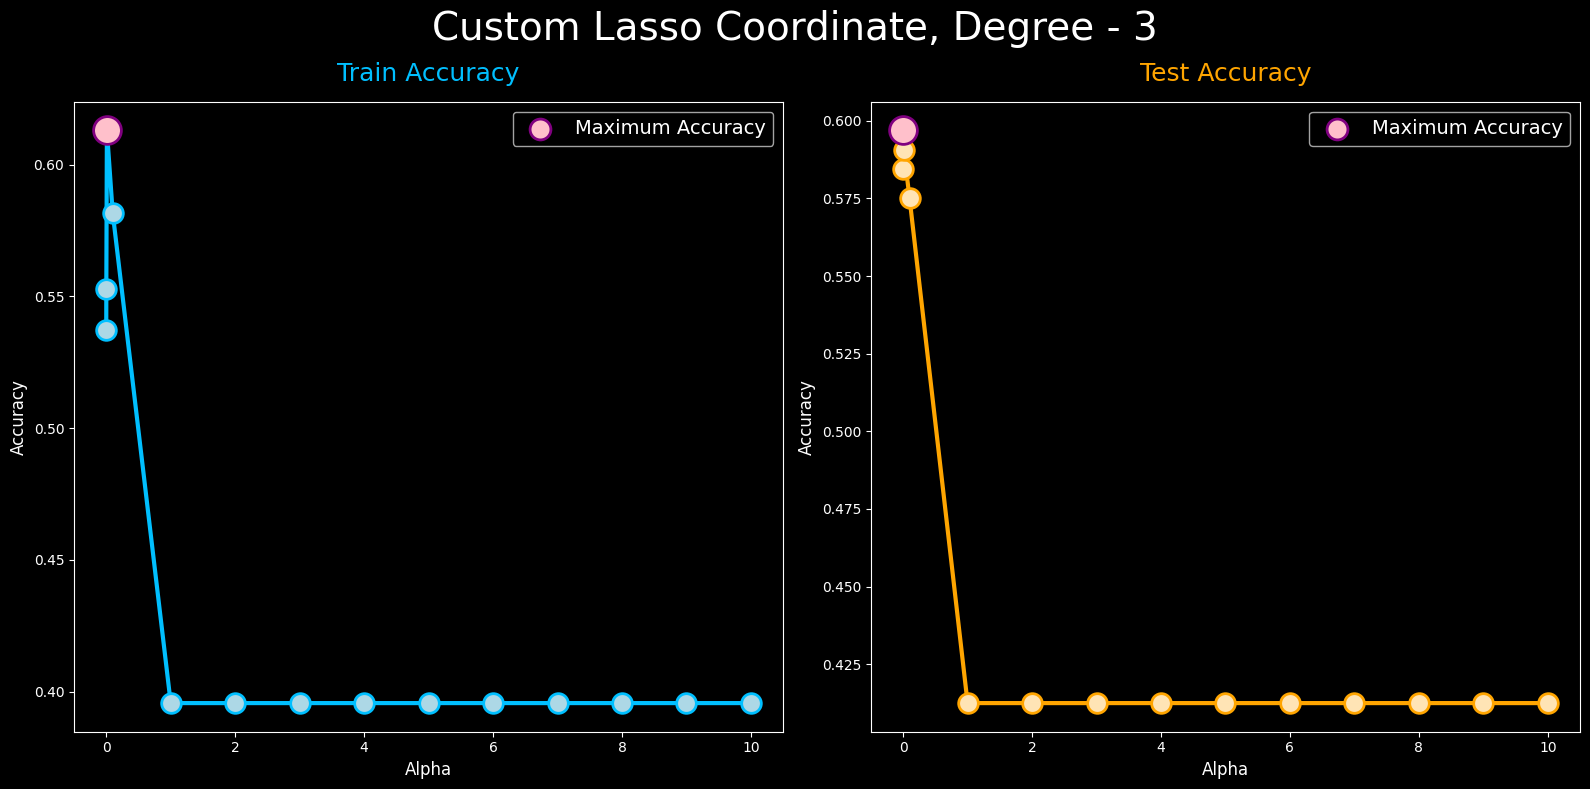

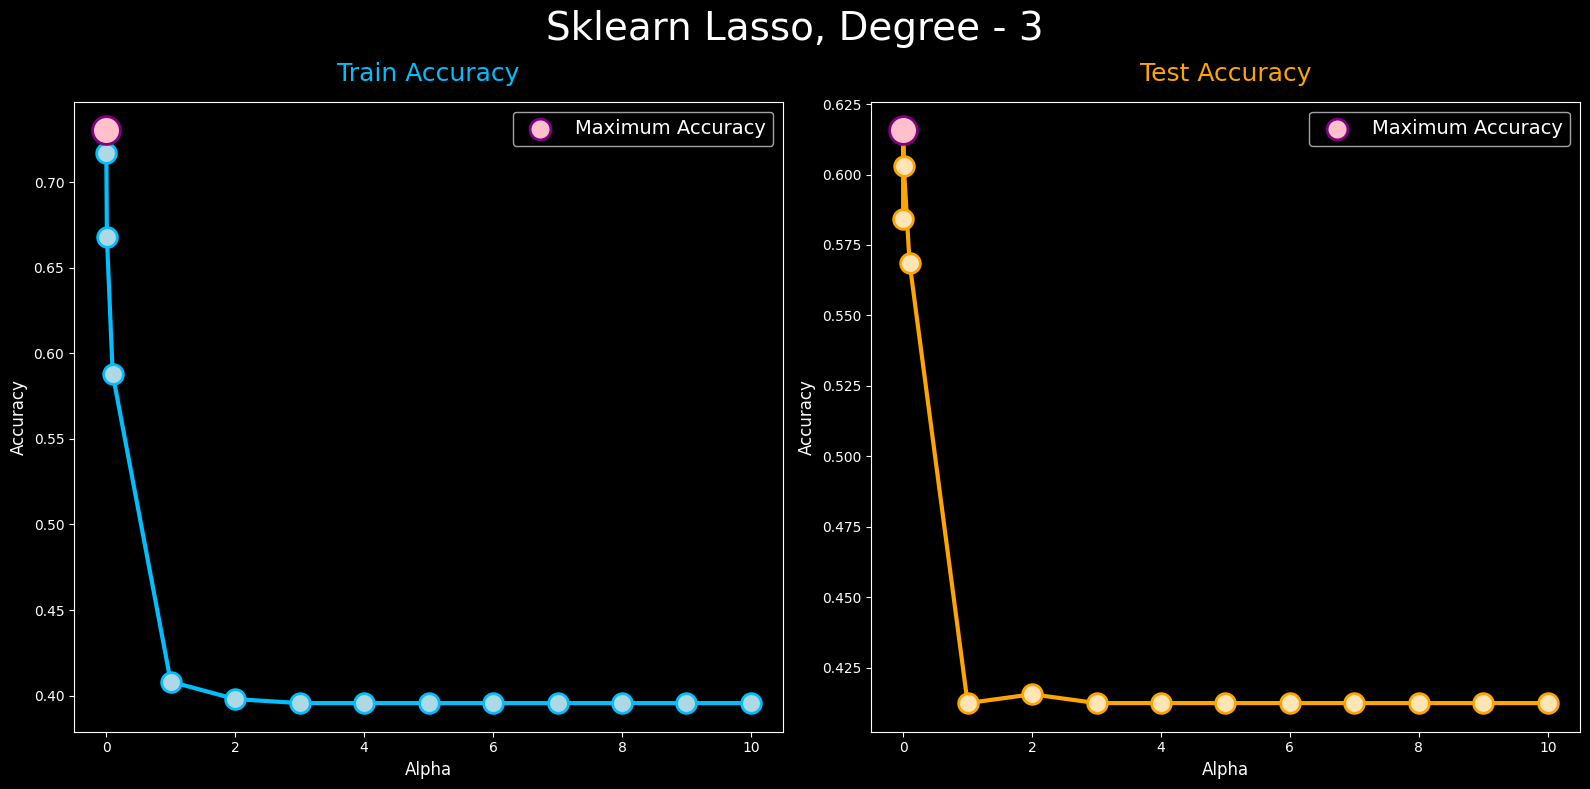

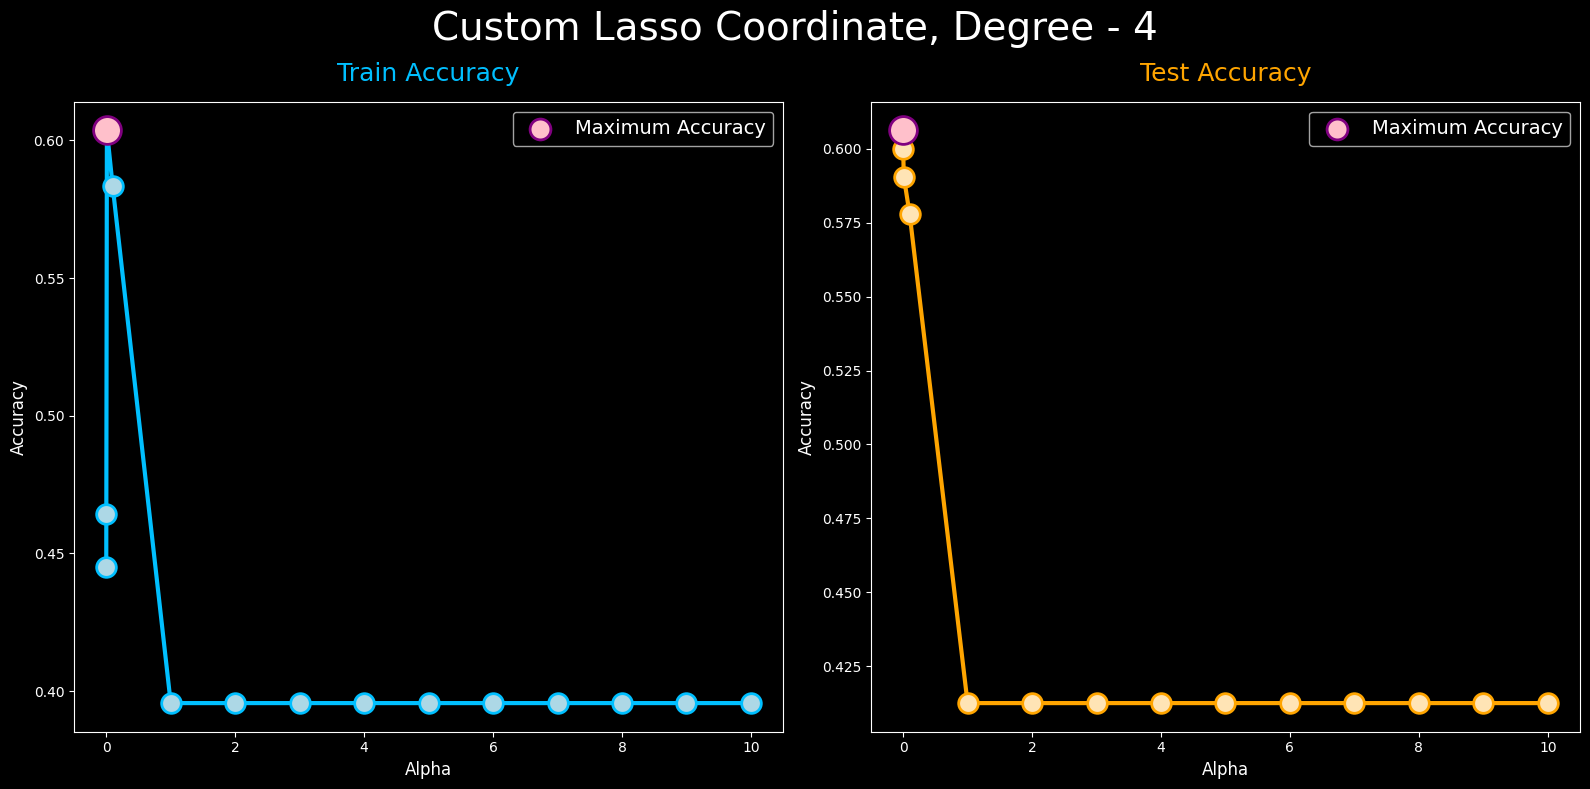

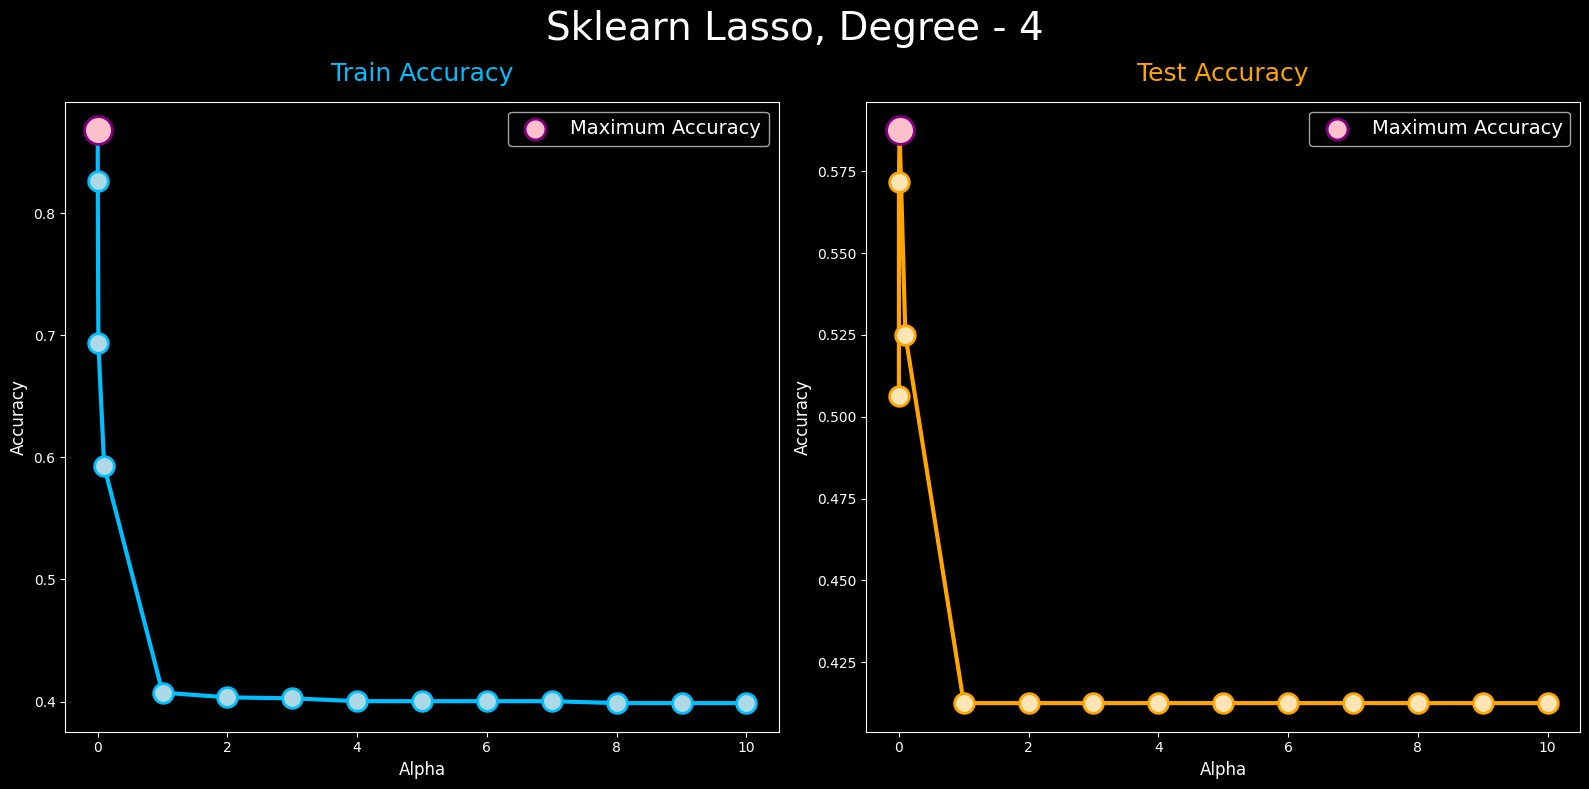

In [28]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
models_degrees_data = get_model_train_test_accuracies(degrees=degrees, models=models, alphas=alphas,
                                                      coordinate_iterations=10)
plot_model_accuracies(models_degrees_data=models_degrees_data)

In [29]:
get_models_report(models_degrees_data=models_degrees_data)

Model:                 Custom Lasso Coordinate
Degree:                3
Max train accuracy:    0.6129788897576232
Max train alpha:       0.01
Max test accuracy:     0.596875
Max test alpha:        0.0001
----------------------------------------
Model:                 Sklearn Lasso
Degree:                3
Max train accuracy:    0.7302580140734949
Max train alpha:       0.0001
Max test accuracy:     0.615625
Max test alpha:        0.001
----------------------------------------
Model:                 Custom Lasso Coordinate
Degree:                4
Max train accuracy:    0.6035965598123534
Max train alpha:       0.01
Max test accuracy:     0.60625
Max test alpha:        0.0001
----------------------------------------
Model:                 Sklearn Lasso
Degree:                4
Max train accuracy:    0.8678655199374511
Max train alpha:       0.0001
Max test accuracy:     0.5875
Max test alpha:        0.01
----------------------------------------


### Lasso Coordinate Descent vs Lasso Gradient Descent

I will compare my custom built Lasso Regularization model which uses Coordinate Descent as optimization algorithm and my another one custom build Lasso Regularization model which uses Gradient Descent as it's optimization algorithm.

In [30]:
models = [
    {
        "model": LassoCoordinate,
        "title": "Custom Lasoo Coordinate"
    },
    {
        "model": LassoGradient,
        "title": "Custom Lasso Gradient"
    }
]

C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:28: RuntimeWarning: invalid value encountered in cast
  y_pred = np.round(regression.predict(X_test_pf)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:29: RuntimeWarning: invalid value encountered in cast
  y_pred_train = np.round(regression.intercept_ + np.dot(X_train_pf, regression.coef_)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:28: RuntimeWarning: invalid value encountered in cast
  y_pred = np.round(regression.predict(X_test_pf)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:29: RuntimeWarning: invalid value encountered in cast
  y_pred_train = np.round(regression.intercept_ + np.dot(X_train_pf, regression.coef_)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:28: RuntimeWarning: invalid value encountered in cast
  y_pred = np.round(regression.predict(X_test_pf)).astype(int)
C:\Users\Pe

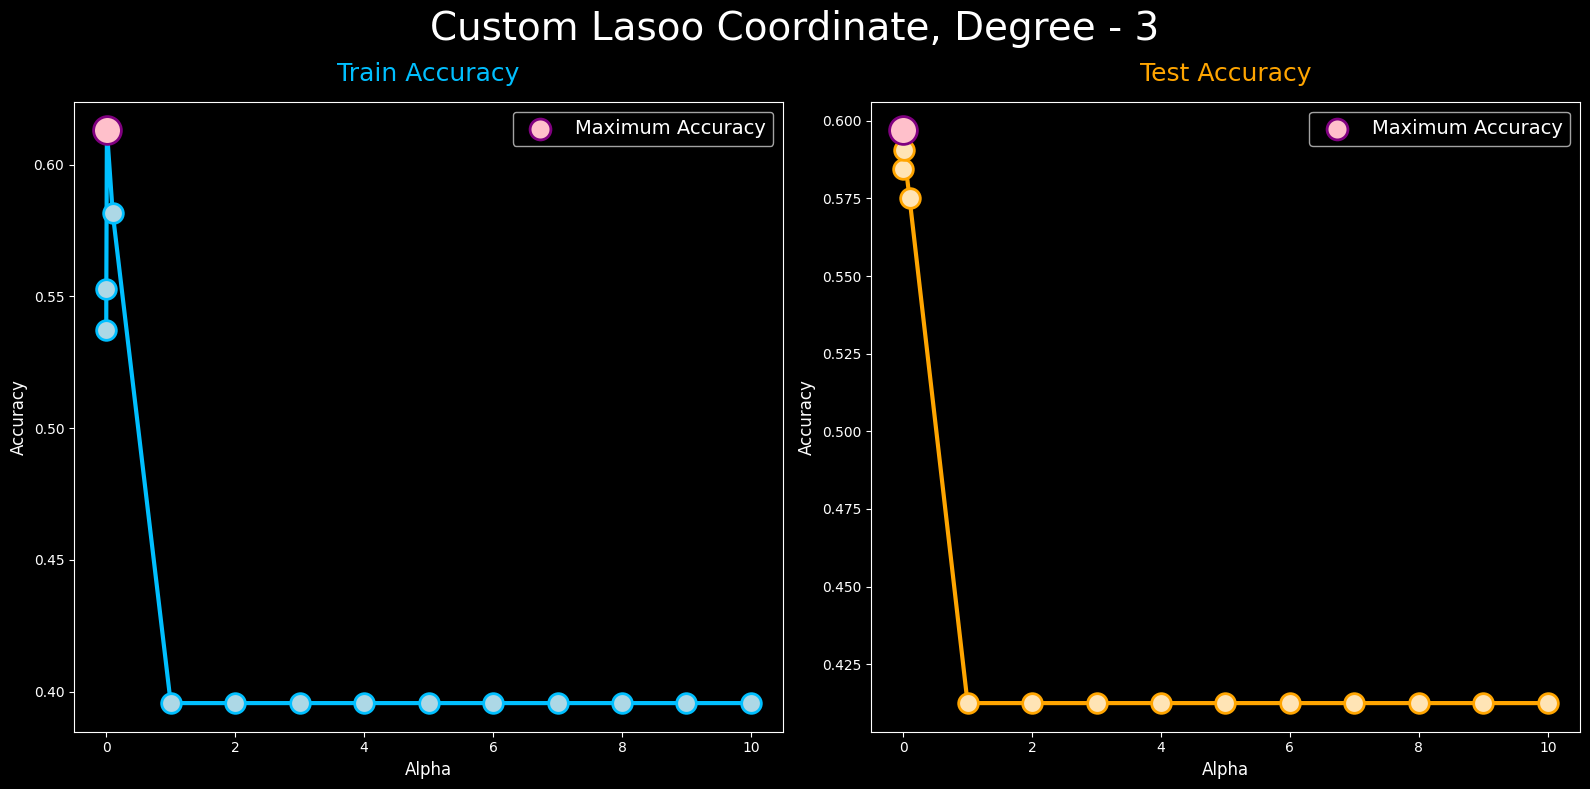

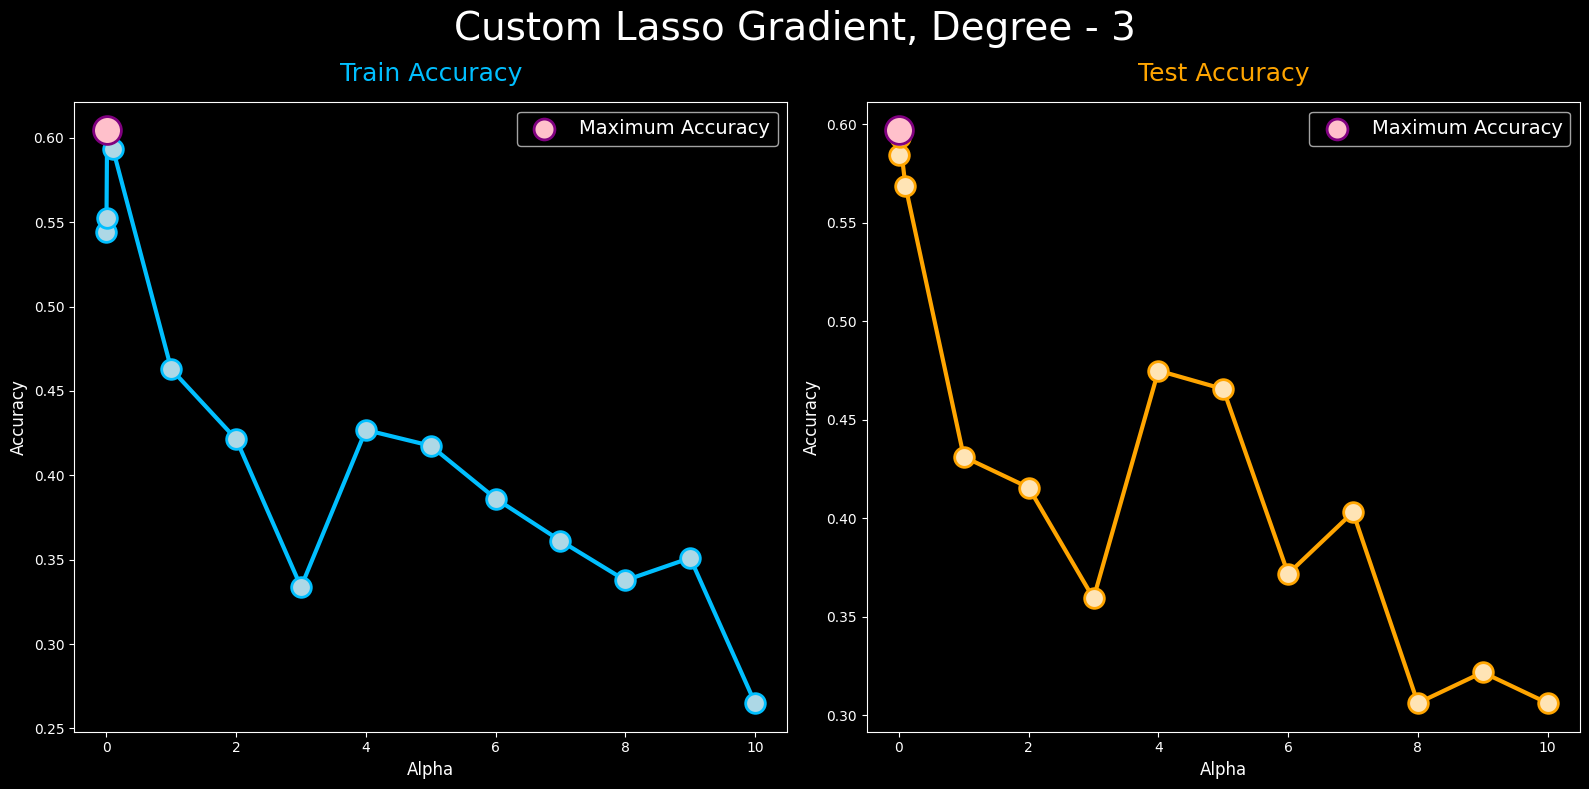

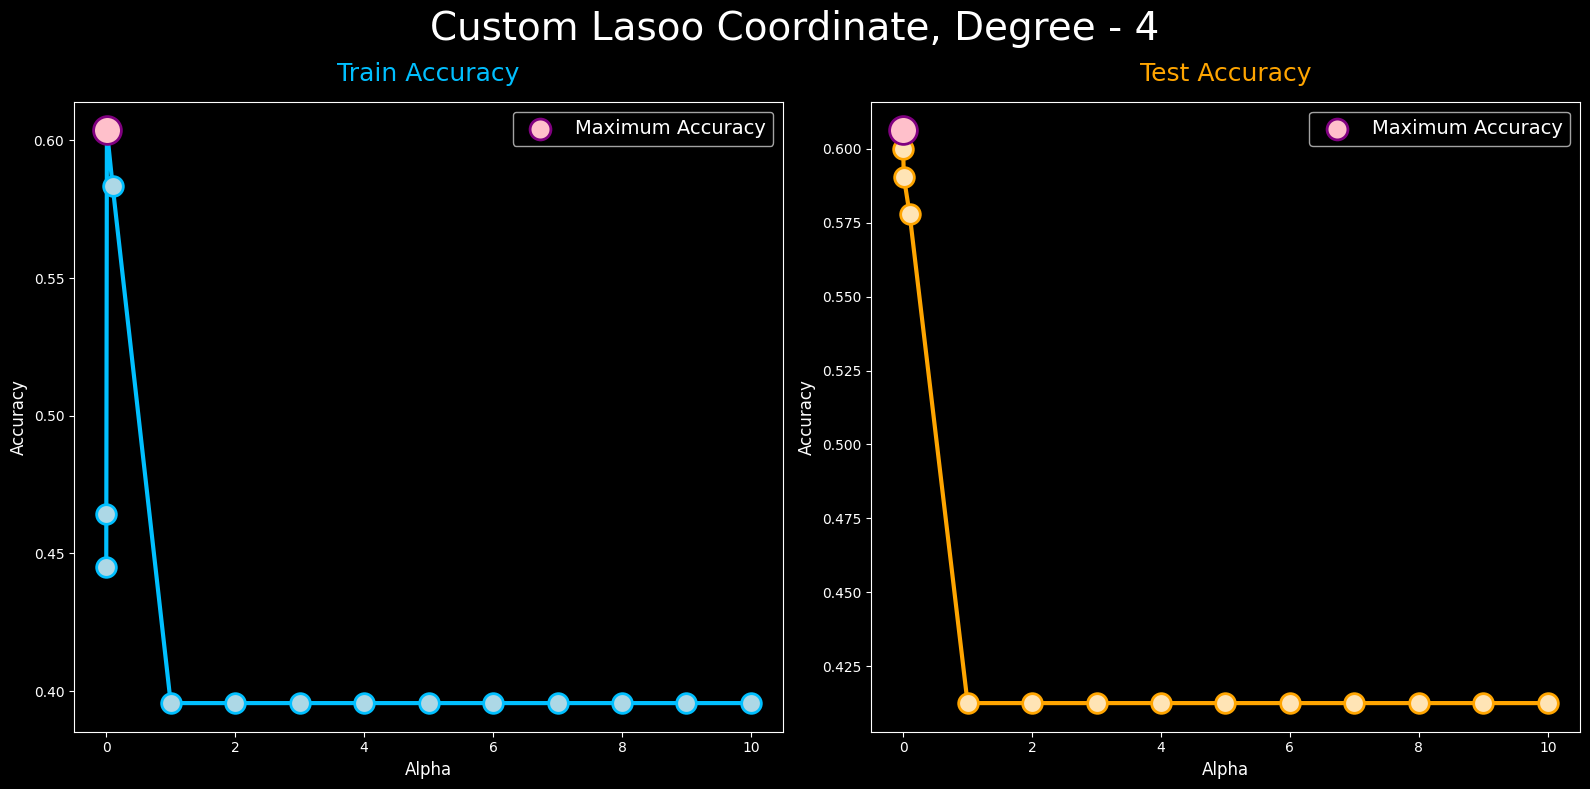

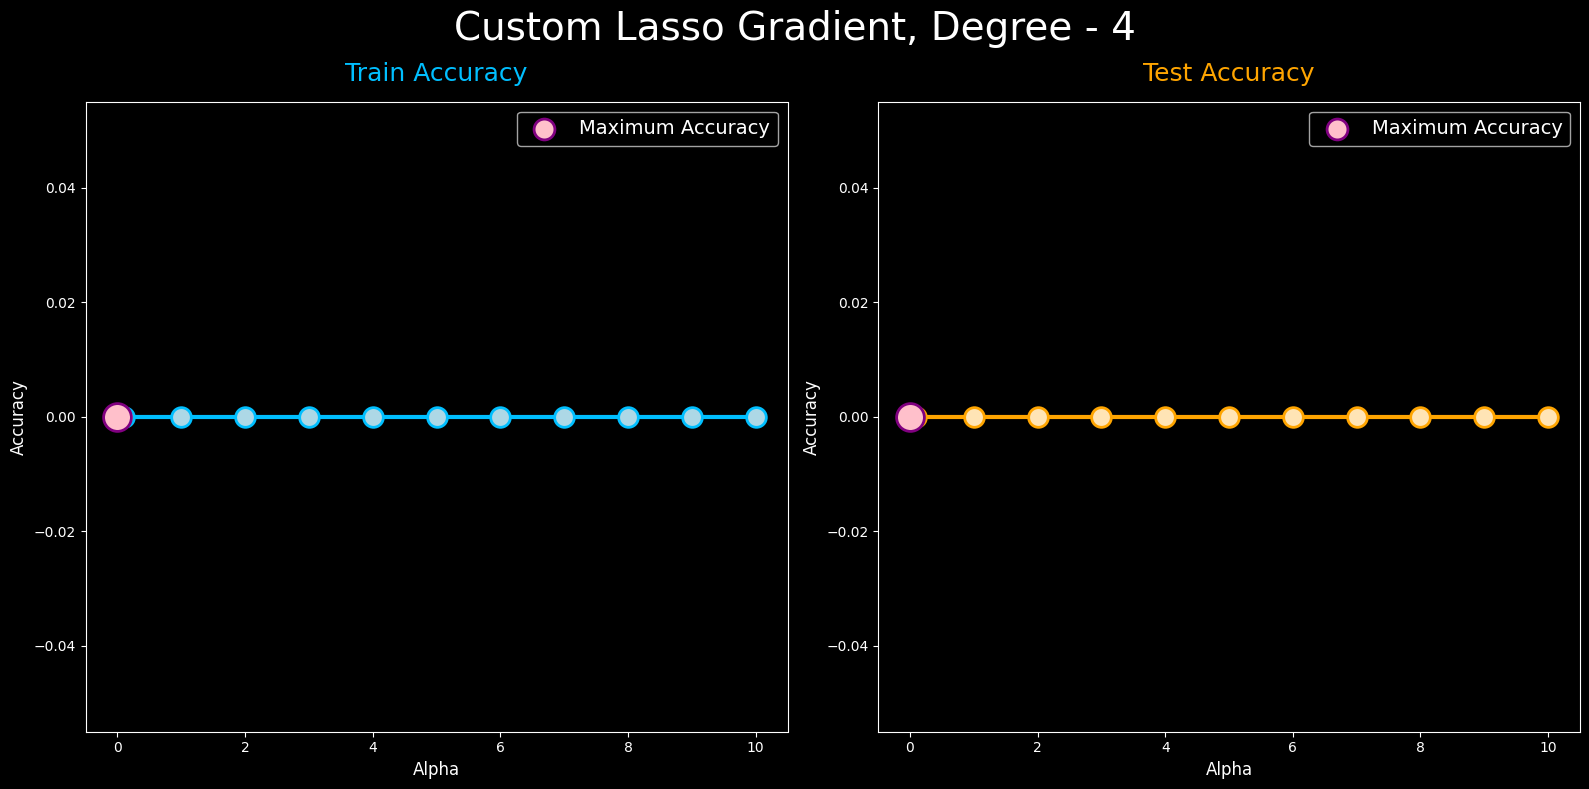

In [31]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
models_degrees_data = get_model_train_test_accuracies(degrees=degrees, models=models, alphas=alphas, 
                            coordinate_iterations=10, gradient_iterations=1000, learning_rate=0.01) # extra parameter for gradient descent optimization
plot_model_accuracies(models_degrees_data=models_degrees_data)

In [32]:
get_models_report(models_degrees_data=models_degrees_data)

Model:                 Custom Lasoo Coordinate
Degree:                3
Max train accuracy:    0.6129788897576232
Max train alpha:       0.01
Max test accuracy:     0.596875
Max test alpha:        0.0001
----------------------------------------
Model:                 Custom Lasso Gradient
Degree:                3
Max train accuracy:    0.6043784206411259
Max train alpha:       0.01
Max test accuracy:     0.596875
Max test alpha:        0.0001
----------------------------------------
Model:                 Custom Lasoo Coordinate
Degree:                4
Max train accuracy:    0.6035965598123534
Max train alpha:       0.01
Max test accuracy:     0.60625
Max test alpha:        0.0001
----------------------------------------
Model:                 Custom Lasso Gradient
Degree:                4
Max train accuracy:    0.0
Max train alpha:       0.0001
Max test accuracy:     0.0
Max test alpha:        0.0001
----------------------------------------


## Elastic Net

### Custom ElasticNet vs Sklearn ElasticNet

I will compare my custom built ElasticNet Regularization model which uses Coordinate Descent as optimization algorithm and ElasticNet model from sklearn.

In [33]:
models = [
    {
        "model": ElasticNetCoordinate,
        "title": "Custom ElasticNet Coordinate"
    },
    {
        "model": ElasticNet,
        "title": "Sklearn ElasticNet"
    }
]

C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+02, tolerance: 8.321e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+02, tolerance: 8.321e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalC

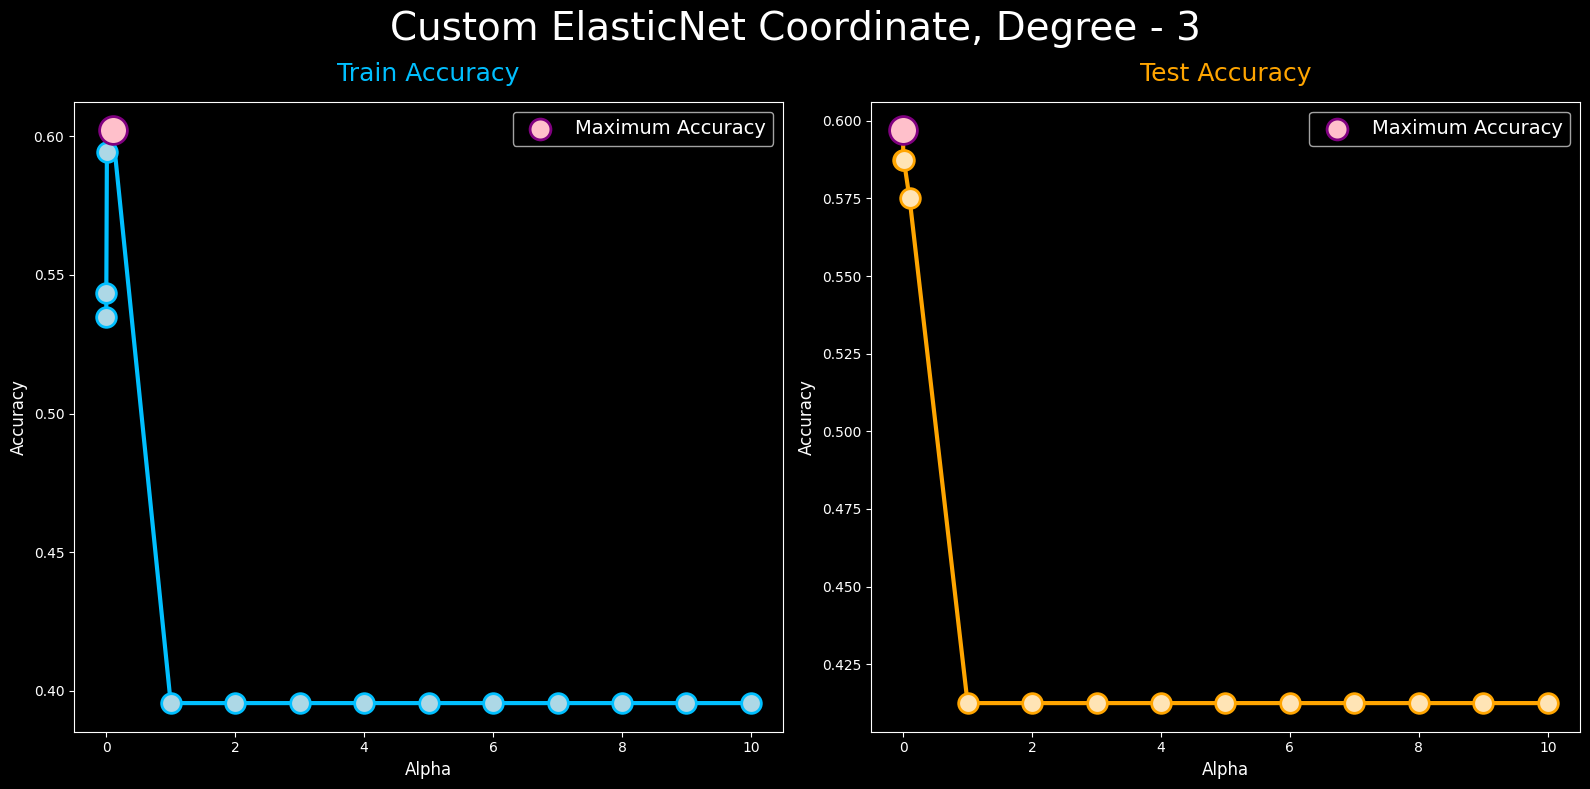

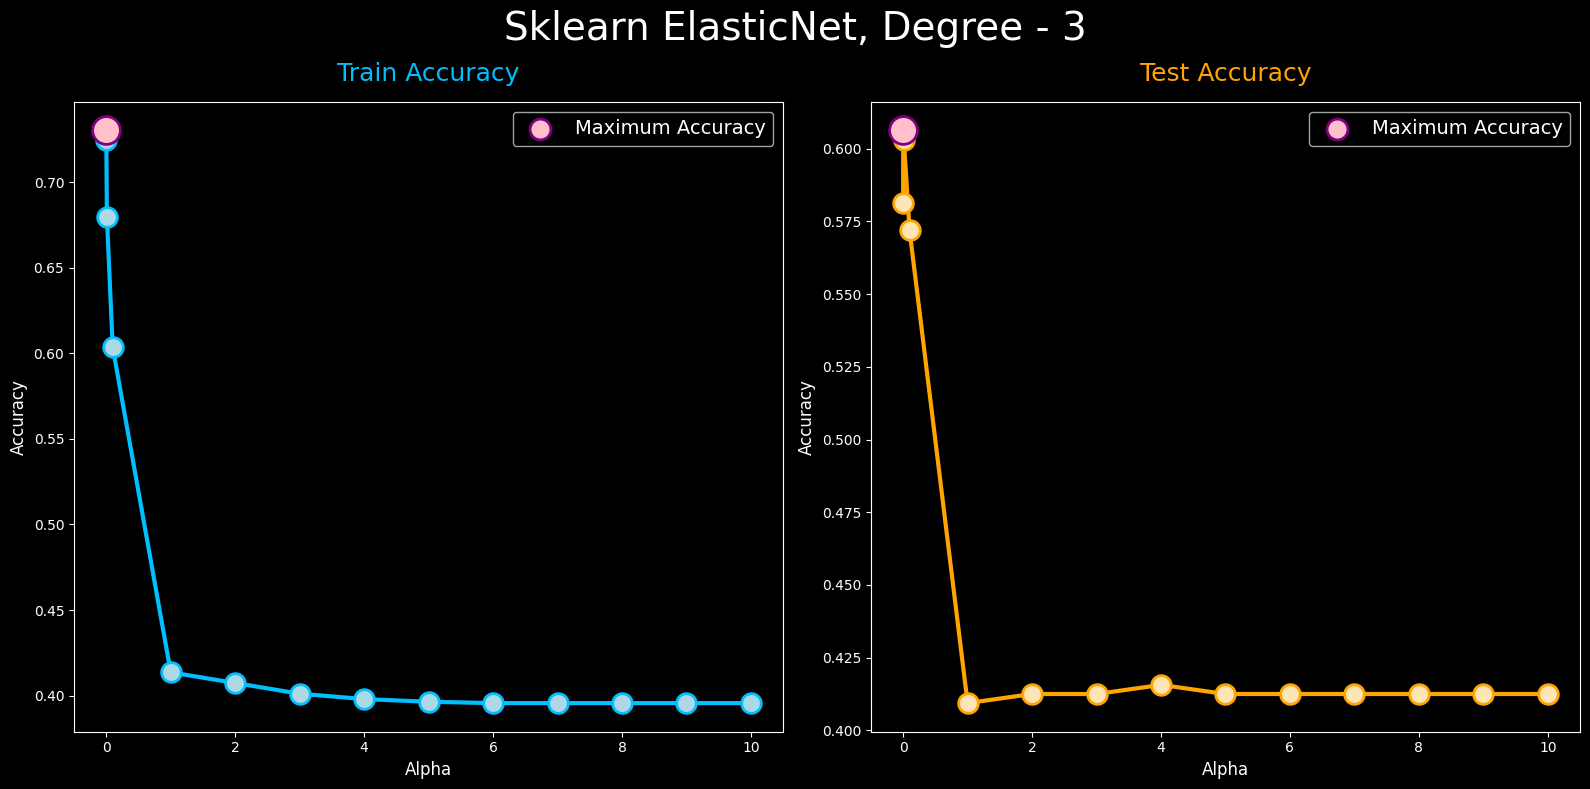

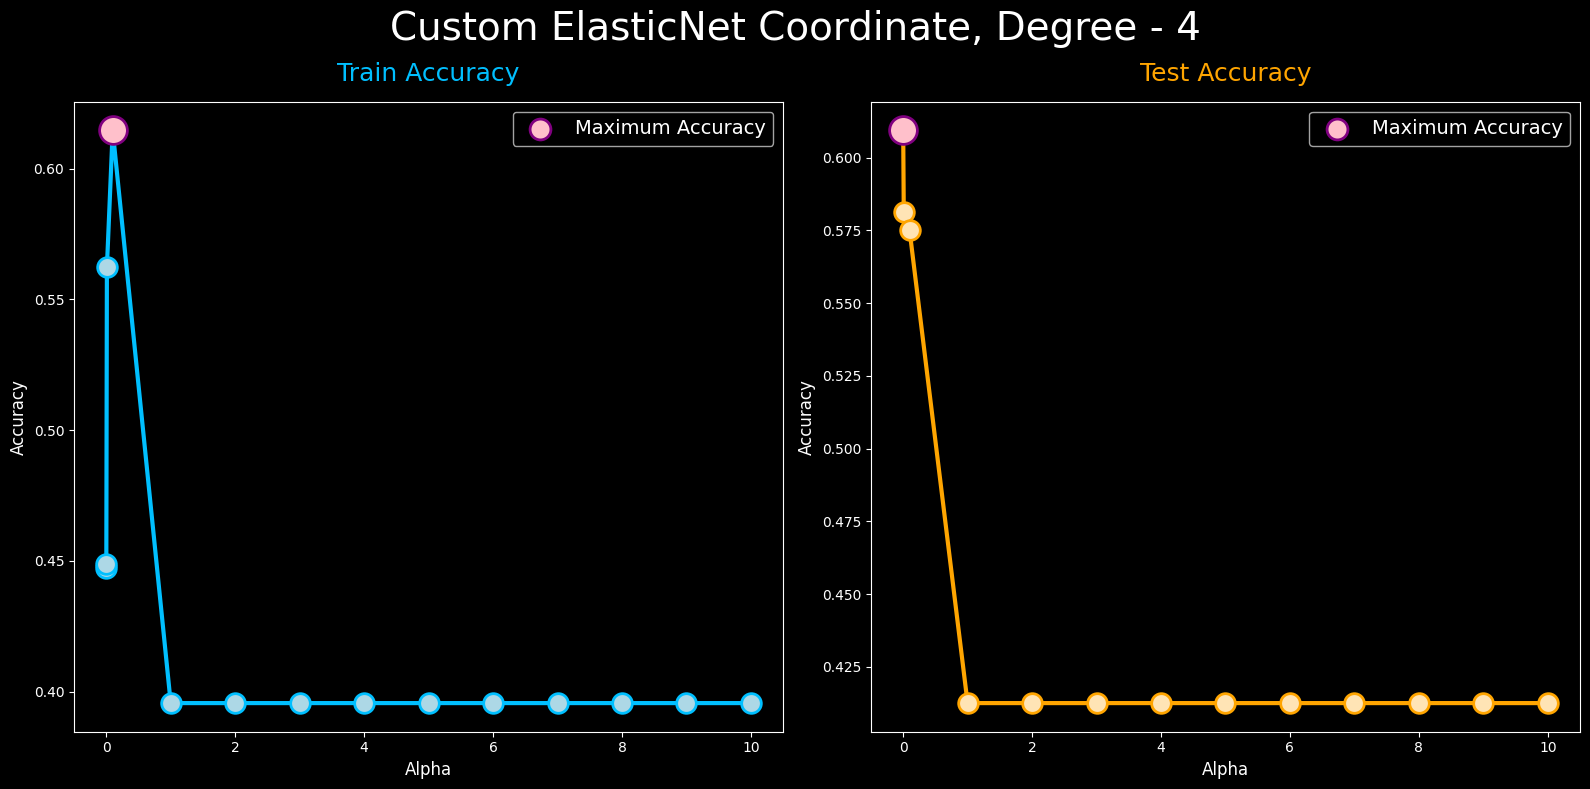

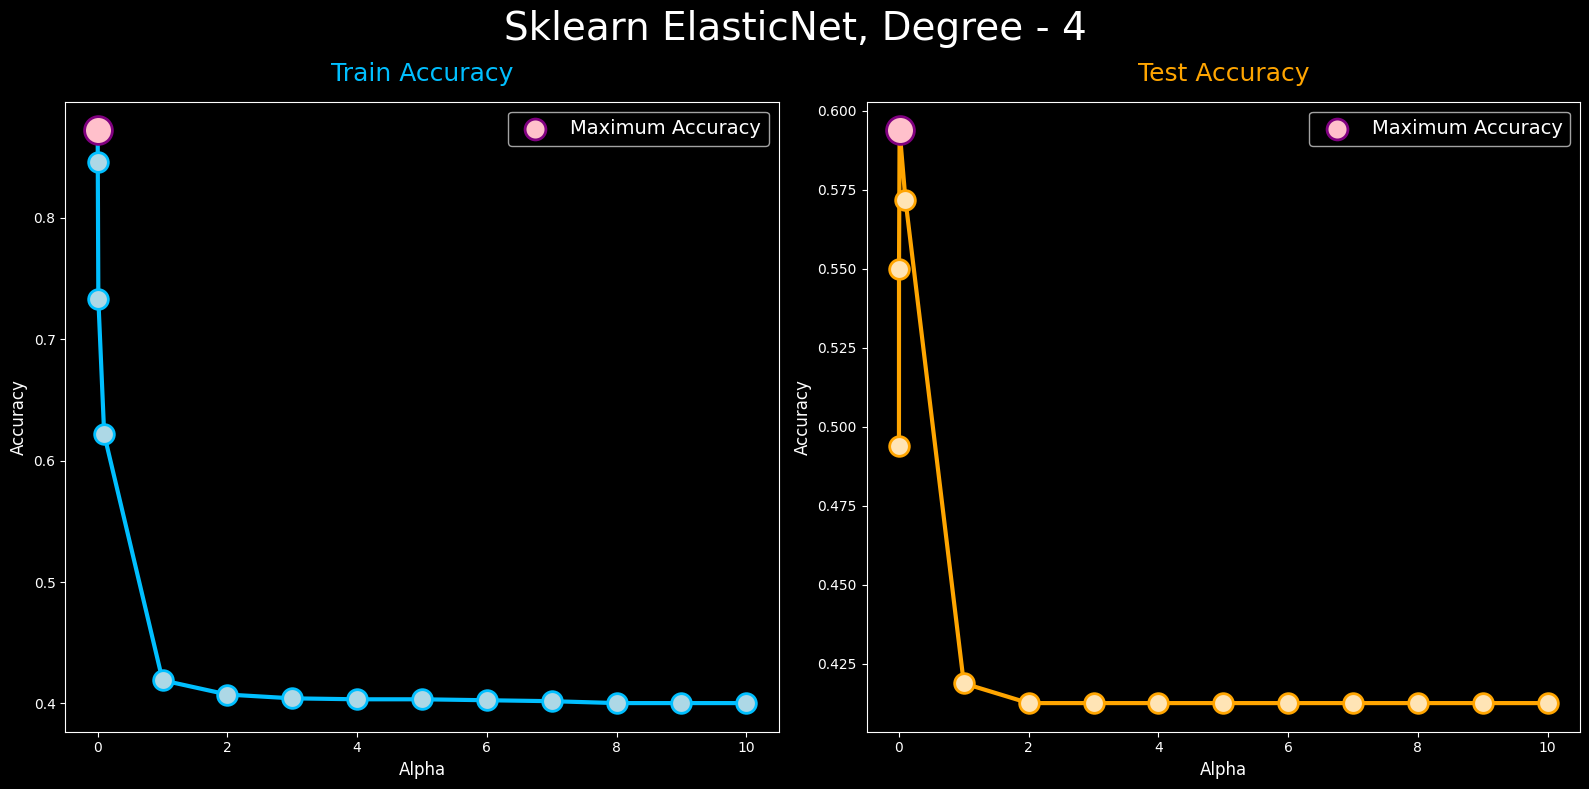

In [34]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
models_degrees_data = get_model_train_test_accuracies(degrees=degrees, models=models, alphas=alphas, 
                                                      coordinate_iterations=10, l1_ratio=0.5)
plot_model_accuracies(models_degrees_data=models_degrees_data)

In [35]:
get_models_report(models_degrees_data=models_degrees_data)

Model:                 Custom ElasticNet Coordinate
Degree:                3
Max train accuracy:    0.6020328381548085
Max train alpha:       0.1
Max test accuracy:     0.596875
Max test alpha:        0.0001
----------------------------------------
Model:                 Sklearn ElasticNet
Degree:                3
Max train accuracy:    0.7302580140734949
Max train alpha:       0.0001
Max test accuracy:     0.60625
Max test alpha:        0.001
----------------------------------------
Model:                 Custom ElasticNet Coordinate
Degree:                4
Max train accuracy:    0.6145426114151681
Max train alpha:       0.1
Max test accuracy:     0.609375
Max test alpha:        0.0001
----------------------------------------
Model:                 Sklearn ElasticNet
Degree:                4
Max train accuracy:    0.8717748240813136
Max train alpha:       0.0001
Max test accuracy:     0.59375
Max test alpha:        0.01
----------------------------------------


### ElasticNet Coordinate Descent vs ElasticNet Gradient Descent

I will compare my custom built ElasticNet Regularization model which uses Coordinate Descent as optimization algorithm and my another one custom built ElasticNet model which uses Gradient Descent as its optimization algorithm.

In [36]:
models = [
    {
        "model": ElasticNetCoordinate,
        "title": "Custom ElasticNet Coordinate"
    },
    {
        "model": ElasticNetGradient,
        "title": "Custom ElasticNet Gradient"
    }
]

C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:28: RuntimeWarning: invalid value encountered in cast
  y_pred = np.round(regression.predict(X_test_pf)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:29: RuntimeWarning: invalid value encountered in cast
  y_pred_train = np.round(regression.intercept_ + np.dot(X_train_pf, regression.coef_)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:28: RuntimeWarning: invalid value encountered in cast
  y_pred = np.round(regression.predict(X_test_pf)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:29: RuntimeWarning: invalid value encountered in cast
  y_pred_train = np.round(regression.intercept_ + np.dot(X_train_pf, regression.coef_)).astype(int)
C:\Users\Personal\AppData\Local\Temp\ipykernel_7656\2554168517.py:28: RuntimeWarning: invalid value encountered in cast
  y_pred = np.round(regression.predict(X_test_pf)).astype(int)
C:\Users\Pe

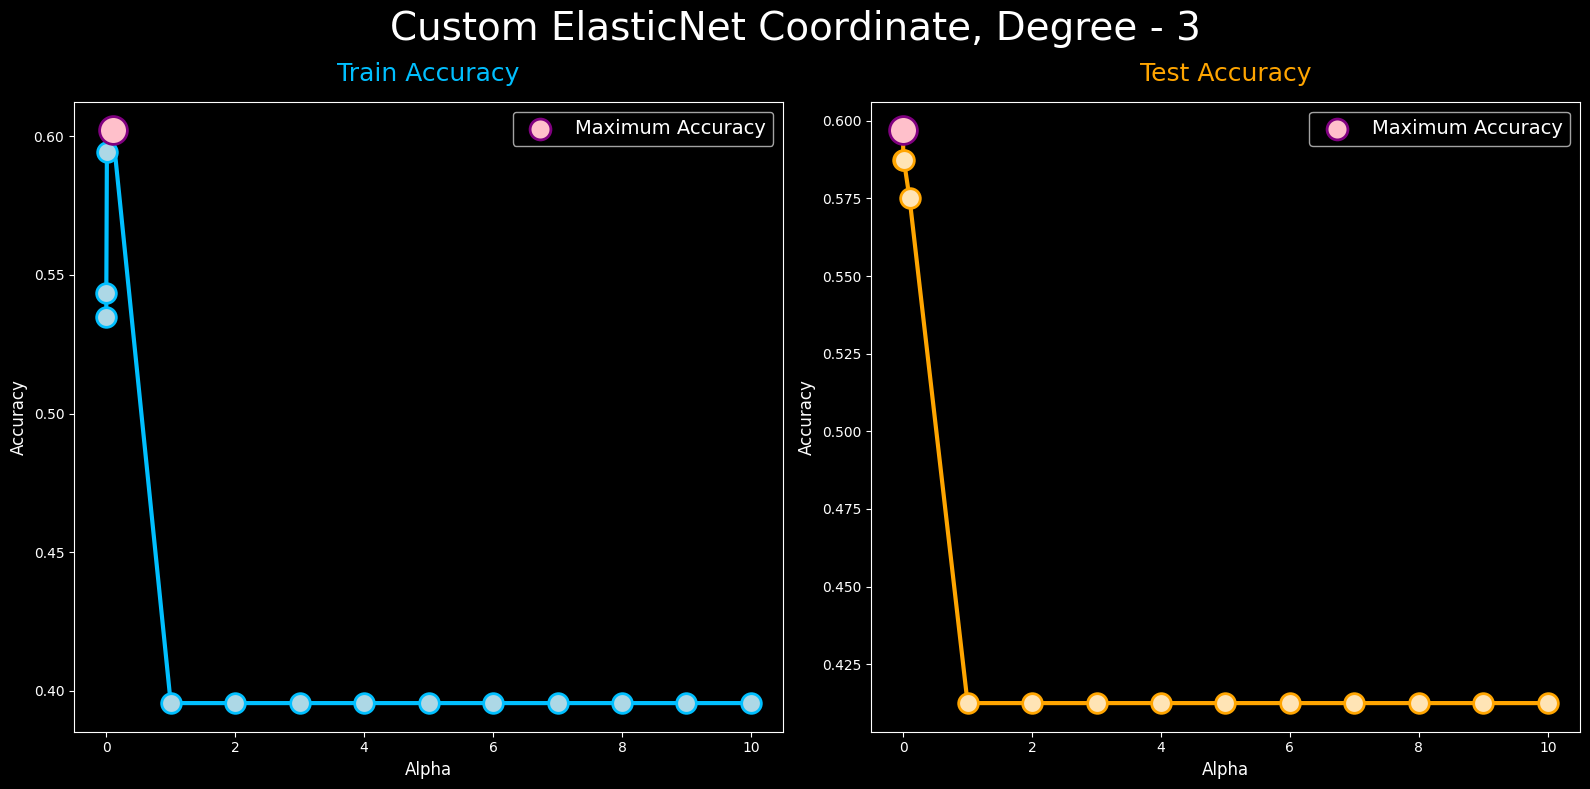

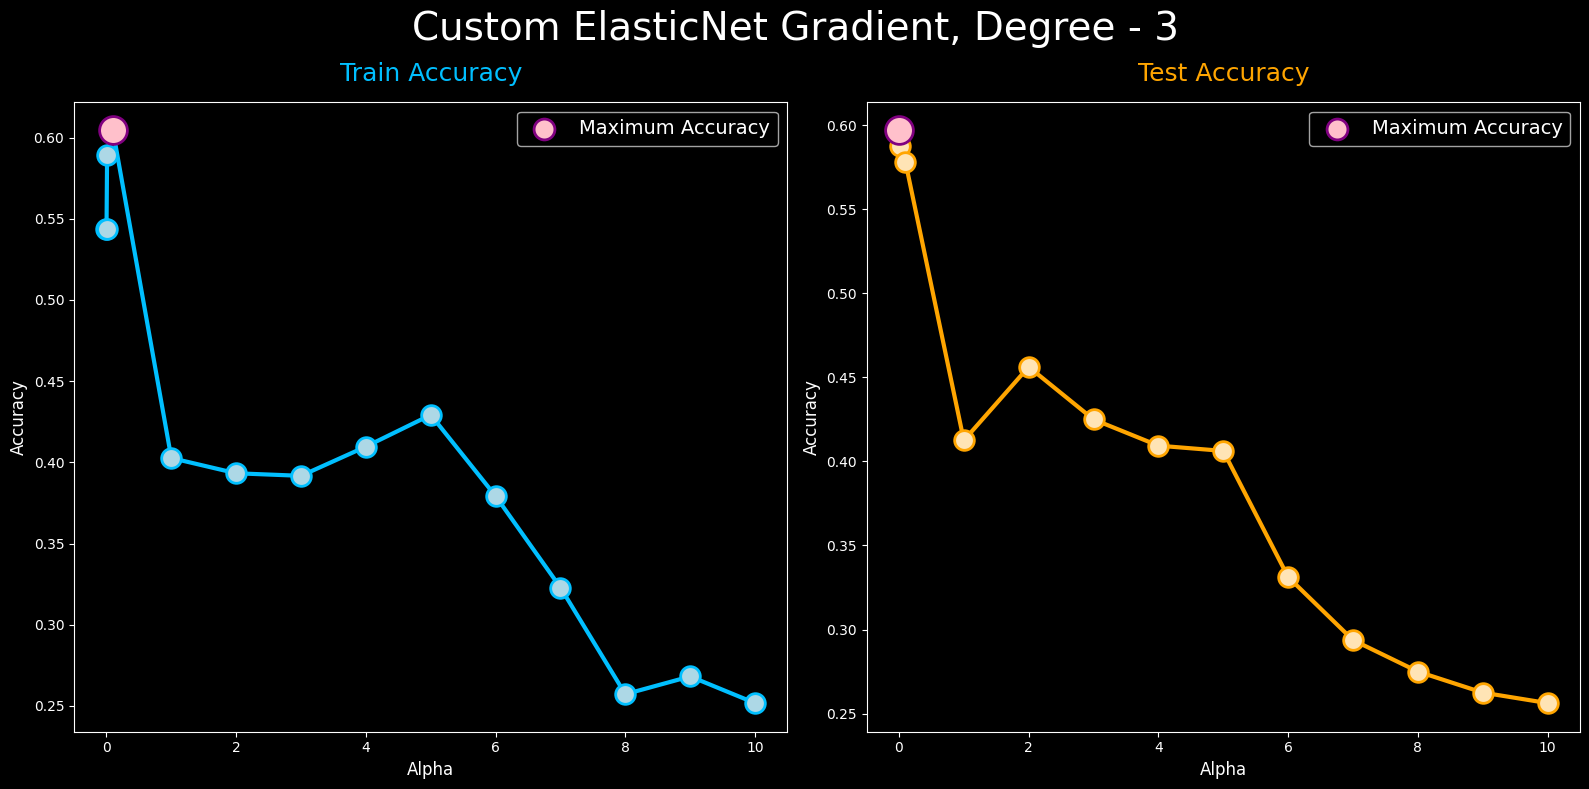

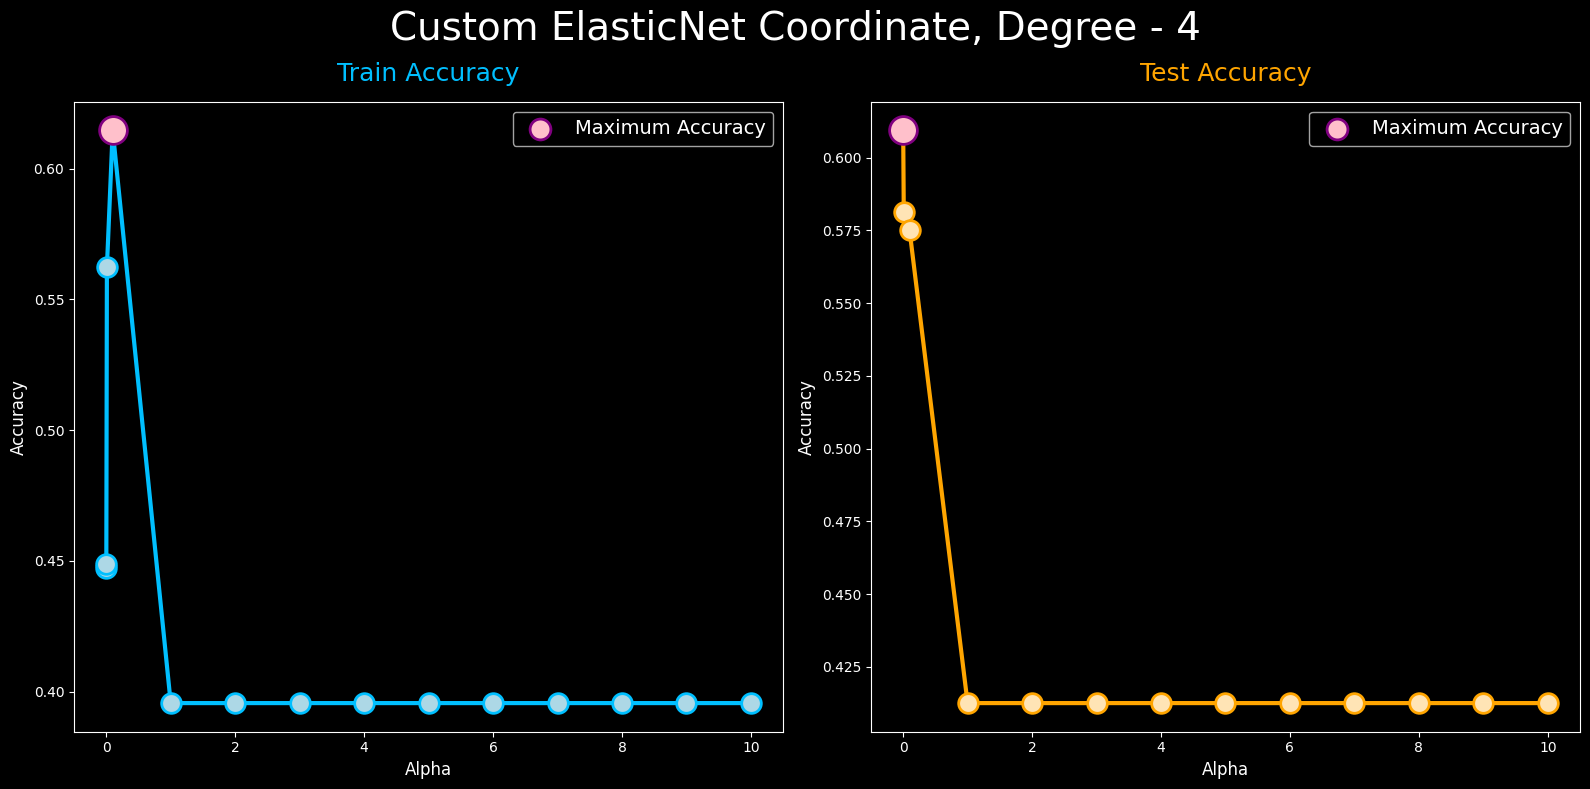

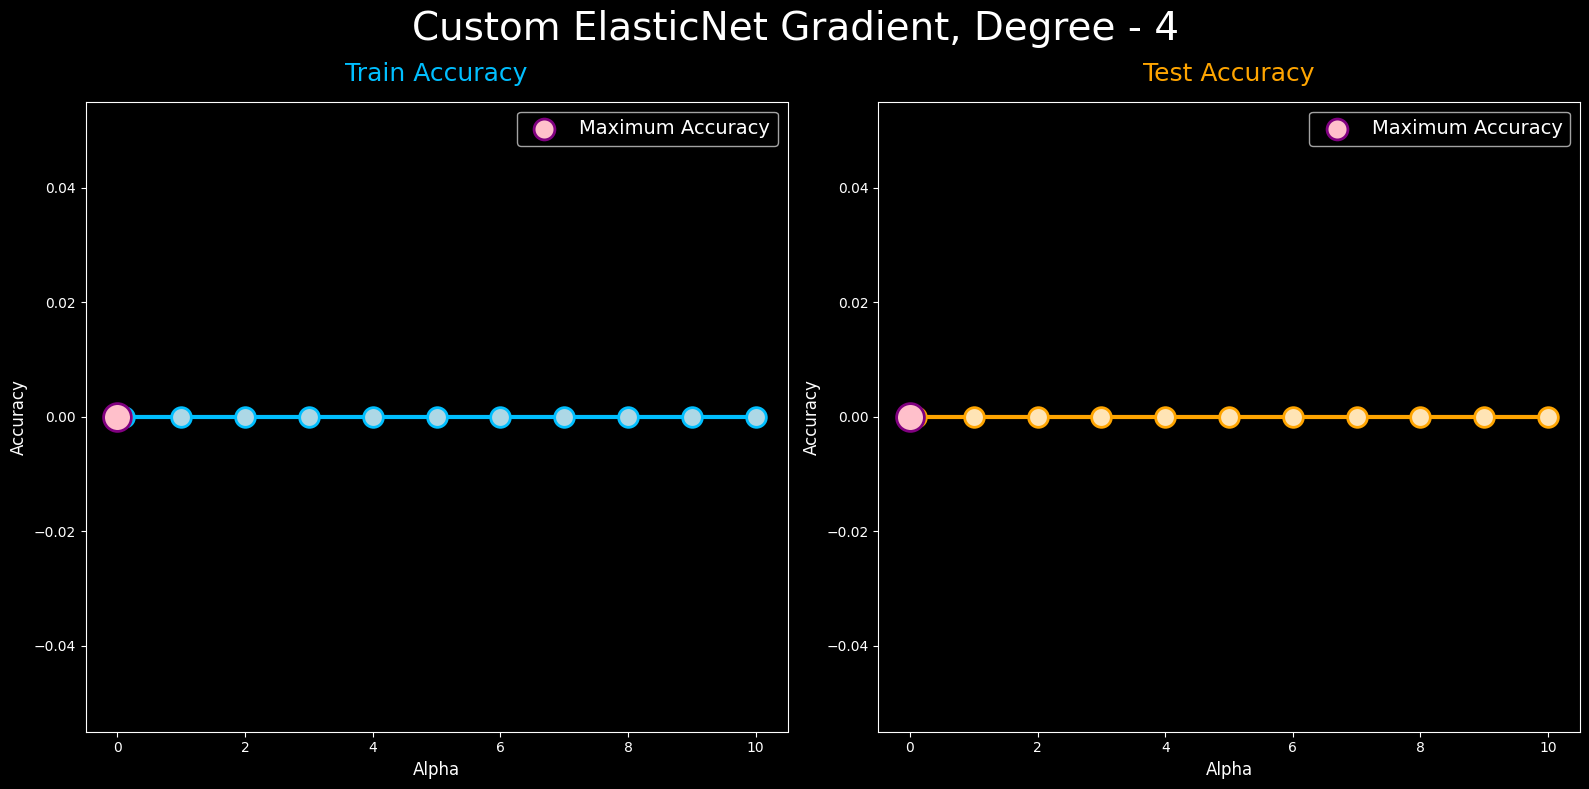

In [37]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
models_degrees_data = get_model_train_test_accuracies(degrees=degrees, models=models, alphas=alphas, 
                            coordinate_iterations=10, gradient_iterations=1000, learning_rate=0.01, l1_ratio=0.5) 

plot_model_accuracies(models_degrees_data=models_degrees_data)

In [38]:
get_models_report(models_degrees_data=models_degrees_data)

Model:                 Custom ElasticNet Coordinate
Degree:                3
Max train accuracy:    0.6020328381548085
Max train alpha:       0.1
Max test accuracy:     0.596875
Max test alpha:        0.0001
----------------------------------------
Model:                 Custom ElasticNet Gradient
Degree:                3
Max train accuracy:    0.6043784206411259
Max train alpha:       0.1
Max test accuracy:     0.596875
Max test alpha:        0.0001
----------------------------------------
Model:                 Custom ElasticNet Coordinate
Degree:                4
Max train accuracy:    0.6145426114151681
Max train alpha:       0.1
Max test accuracy:     0.609375
Max test alpha:        0.0001
----------------------------------------
Model:                 Custom ElasticNet Gradient
Degree:                4
Max train accuracy:    0.0
Max train alpha:       0.0001
Max test accuracy:     0.0
Max test alpha:        0.0001
----------------------------------------


## Cross Validation and GridSearchCV

Since ElasticNet model has both Lasso and Ridge regressions we will optimize ElasticNet model to find best parameters with GridSearchCV

In [39]:
from sklearn.model_selection import GridSearchCV, KFold
from joblib import Parallel, delayed

degrees = [3, 4]

report_data = []

def run_grid_search(degree):
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    elastic_net = ElasticNet()

    alpha = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100]
    l1_ratio = np.linspace(0, 1, 11)
    fit_intercept = [True, False]
    precompute = [True, False]
    max_iter = [100, 1000, 10000]
    warm_start = [True, False]
    positive = [True, False]
    selection = ["cyclic", "random"]

    params = {
        "alpha": alpha,
        "l1_ratio": l1_ratio,
        "fit_intercept": fit_intercept,
        "precompute": precompute,
        "max_iter": max_iter,
        "warm_start": warm_start,
        "positive": positive,
        "selection": selection
    }

    elastic_net_GS = GridSearchCV(estimator=elastic_net, param_grid=params, cv=cv, n_jobs=-1, verbose=3)

    pf = PolynomialFeatures(degree=degree)
    X_train_pf = pf.fit_transform(X_train)
    X_test_pf = pf.transform(X_test)

    elastic_net_GS.fit(X=X_train_pf, y=y_train)
    y_pred = elastic_net_GS.predict(X=X_test_pf)

    return {
        "degree" : degree,
        "best_params_": elastic_net_GS.best_params_,
        "y_pred": y_pred
    }


report_data.append(
    Parallel(n_jobs=-1)(delayed(run_grid_search)(degree) for degree in degrees)
)

# for degree in degrees:
#     report_data = run_grid_search(degree)
#     print(report_data)

KeyboardInterrupt: 

In [8]:
from sklearn.model_selection import GridSearchCV, KFold
from joblib import Parallel, delayed
import time


start_time = time.time()
cv = KFold(n_splits=10, shuffle=True, random_state=42)

elastic_net = ElasticNet()

alpha = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100]
l1_ratio = np.linspace(0, 1, 11)
fit_intercept = [True, False]
precompute = [True, False]
max_iter = [100, 1000]
warm_start = [True, False]
positive = [True, False]
selection = ["cyclic", "random"]

params_limited = {
    "alpha": alpha[:2],  # Limit to the first 2 alpha values
    "l1_ratio": l1_ratio[:2],  # Limit to the first 2 l1_ratio values
    "fit_intercept": fit_intercept[:1],  # Limit to the first fit_intercept option
    "precompute": precompute[:1],  # Limit to the first precompute option
    "max_iter": max_iter[:1],  # Limit to the first max_iter option
    "warm_start": warm_start[:1],  # Limit to the first warm_start option
    "positive": positive[:1],  # Limit to the first positive option
    "selection": selection[:1]  # Limit to the first selection option
}

elastic_net_GS = GridSearchCV(estimator=elastic_net, param_grid=params_limited, cv=cv, n_jobs=-1, verbose=3)


pf = PolynomialFeatures(degree=3)  # Use degree=3 for estimation
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.transform(X_test)

elastic_net_GS.fit(X=X_train_pf, y=y_train)

end_time = time.time()

# Calculate the time taken for the subset
elapsed_time = end_time - start_time
num_fits = len(alpha[:2]) * len(l1_ratio[:2]) * len(fit_intercept[:1]) * len(precompute[:1]) * len(max_iter[:1]) * len(warm_start[:1]) * len(positive[:1]) * len(selection[:1]) * cv.get_n_splits()
time_per_fit = elapsed_time / num_fits

# Estimate total time
total_time_estimate = time_per_fit * 168960  # Total number of fits
print(f"Estimated total time: {total_time_estimate / 60:.2f} minutes or {total_time_estimate / 3600:.2f} hours")

# for degree in degrees:
#     report_data = run_grid_search(degree)
#     print(report_data)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Estimated total time: 952.50 minutes or 15.88 hours


C:\Users\Personal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.18194285387108, tolerance: 0.08321078967943707
  model = cd_fast.enet_coordinate_descent_gram(
